In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, cross_validate
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, make_scorer
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from yellowbrick.model_selection import LearningCurve
import pickle
import re
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

## О наборе данных
#### Контекст
Важно, чтобы компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции по кредитным картам, чтобы с клиентов не взималась плата за товары, которые они не покупали.

#### Содержание
Набор данных содержит транзакции, совершенные европейскими держателями карт по кредитным картам в сентябре 2013 года.
В этом наборе данных представлены транзакции, произошедшие за два дня, где есть 492 мошеннические транзакции из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничества) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем конфиденциальности составители набора не могут предоставить исходные характеристики и дополнительную справочную информацию о данных. Характеристики V1, V2,… V28 являются основными компонентами, полученными с помощью PCA, единственные признаки, которые не были преобразованы с помощью PCA, - это «Time» и «Amount». Признак «Time» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Признак «Amount» представляет собой сумму транзакции. Признак «Class» — это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

## 1. Изучение набора данных

Выведем саму структуру набора данных (или по другому dataframe).

In [2]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Также стоит отметить, что все признаки в наборе - числовые. Категориальных признаков нет. Это связано с тем, что набор был заранее обработан в целях сохранения конфиденциальности и обезличивания данных.

In [3]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Теперь необходимо проверить есть ли пропущенные значения и посмотреть описательную статистику по каждому из признаков. Стоит отметить также, что в виду примения метода PCA все колонки с именами V* должны быть уже нормализованы, но это также необходимо проверить, чтобы убедиться в этом.

In [4]:
df.isnull().sum().sum()

0

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Все по той же причине уже предобработанных данных набор не содержит пропусков, что очень хорошо, так как лишает нас необходимости дополнительно думать чем заполнять пропуски. А описательная статистика подтверждает, что признаки V* были заранее обработаны, что ожидаемо.
Далее необходимо рассмотреть признаки Amount и Time.

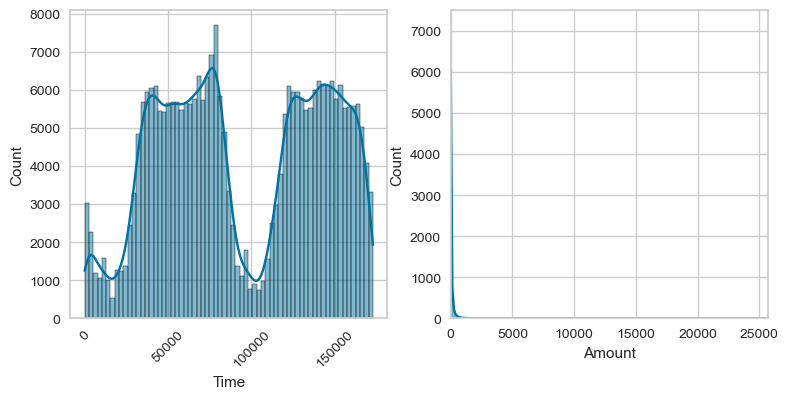

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

sns.histplot(df, x="Time", kde=True, ax=ax[0]);
ax[0].tick_params(axis='x', labelrotation=45);

sns.histplot(df, x="Amount", kde=True, ax=ax[1]);
ax[1].set_xlim([df.Amount.min(), df.Amount.max()])
ax[1].set_ylim([0, 7500])
plt.show()

Ни один ни другой признак не масштабированы, следовательно, - это необходимо сделать, иначе не получится обучить модели достаточно хорошо. Для времени будет использован StandartScaler так как он приводит данные к такому виду, что стандартное отклонение равно 1 и дисперсия равна 1, а среднее  равно 0. Это хорошо влияет на результаты обучения, но не сохраняет форму изначального распределения. Для Amount важна форма изначального распределения, но необходимо уменьшить влияние выбросов, поэтому будет использован RobustScaler.

Но прежде чем это сделать - необходимо разделить данные на выборки. Так как будем подразумевать, что обучаем модель на одних данных, а тестируем на других, то всю предобработку будем делать на тренировочном наборе, а тесты на тестовом, следовательно к тестовым данным будем применять предобработку, которая была создана на тренировочных.

Разбиение на train, test выборки.

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
X, y = df.drop(columns="Class"), df.Class
train_index, test_index = next(split.split(X, y))
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_test, y_test = X.iloc[test_index], y.iloc[test_index]

Масштабирование данных

In [8]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

X_train['scaled_amount'] = rob_scaler.fit_transform(X_train[['Amount']])
X_train.drop(columns="Amount", inplace=True)
X_train['scaled_time'] = std_scaler.fit_transform(X_train[['Time']])
X_train.drop(columns="Time", inplace=True)

X_test['scaled_amount'] = rob_scaler.transform(X_test[['Amount']])
X_test.drop(columns="Amount", inplace=True)
X_test['scaled_time'] = std_scaler.transform(X_test[['Time']])
X_test.drop(columns="Time", inplace=True)

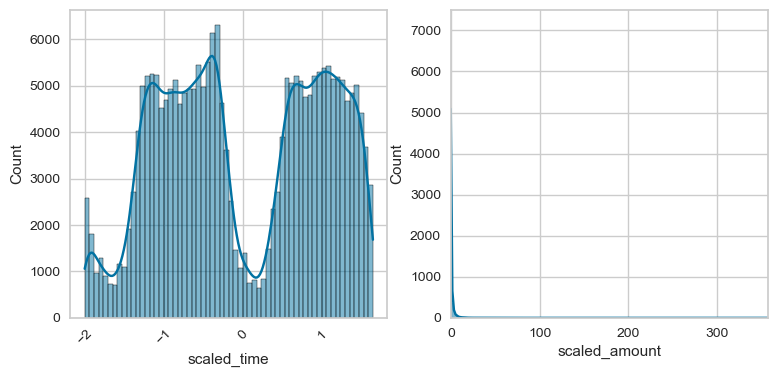

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

sns.histplot(X_train, x="scaled_time", kde=True, ax=ax[0]);
ax[0].tick_params(axis='x', labelrotation=45);

sns.histplot(X_train, x="scaled_amount", kde=True, ax=ax[1]);
ax[1].set_xlim([X_train.scaled_amount.min(), X_train.scaled_amount.max()])
ax[1].set_ylim([0, 7500])
plt.show()

Теперь, когда данные масштабированы, необходимо проверить сбалансированность выборки (как уже известно, она сильно несбалансированна, но нужно в этом убедиться)

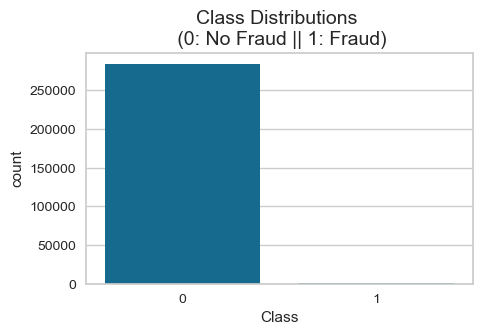

In [10]:
plt.figure(figsize=(5,3))
sns.countplot(df, x="Class")
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

На графике четко видно, что данные сильно несбалансированы, но точные цифры неясны, выведем их на экран. Но очевидно, что необходимо будет применять методы для балансировки классов, иначе невозможно будет достичь удовлетворительного результата.

In [11]:
def print_balance_stat(series):
    print(
        'Не мошеннические операции составляют',
        round(series.value_counts()[0]/len(series) * 100,2),
        '% от всего объема данных'
    )
    print(
        'Мошеннические операции составляют',
        round(series.value_counts()[1]/len(series) * 100,2),
        '% от всего объема данных'
    )
print_balance_stat(df.Class)

Не мошеннические операции составляют 99.83 % от всего объема данных
Мошеннические операции составляют 0.17 % от всего объема данных


Также проверим, что при разделении на train и test классы разделились пропорционально (это ожидаемое поведение использованной функции)

In [12]:
print("_________TRAIN__________")
print_balance_stat(y_train)
print("_________TEST__________")
print_balance_stat(y_test)

_________TRAIN__________
Не мошеннические операции составляют 99.83 % от всего объема данных
Мошеннические операции составляют 0.17 % от всего объема данных
_________TEST__________
Не мошеннические операции составляют 99.83 % от всего объема данных
Мошеннические операции составляют 0.17 % от всего объема данных


Очевидно, что пропорциональность сохранена очень точно, значит результаты тестов будут наиболее приближены к реальности.

Для более точного результата необходимо посмотреть распределение данных в обучающей выборке. Для этого построим несколько диаграмм.

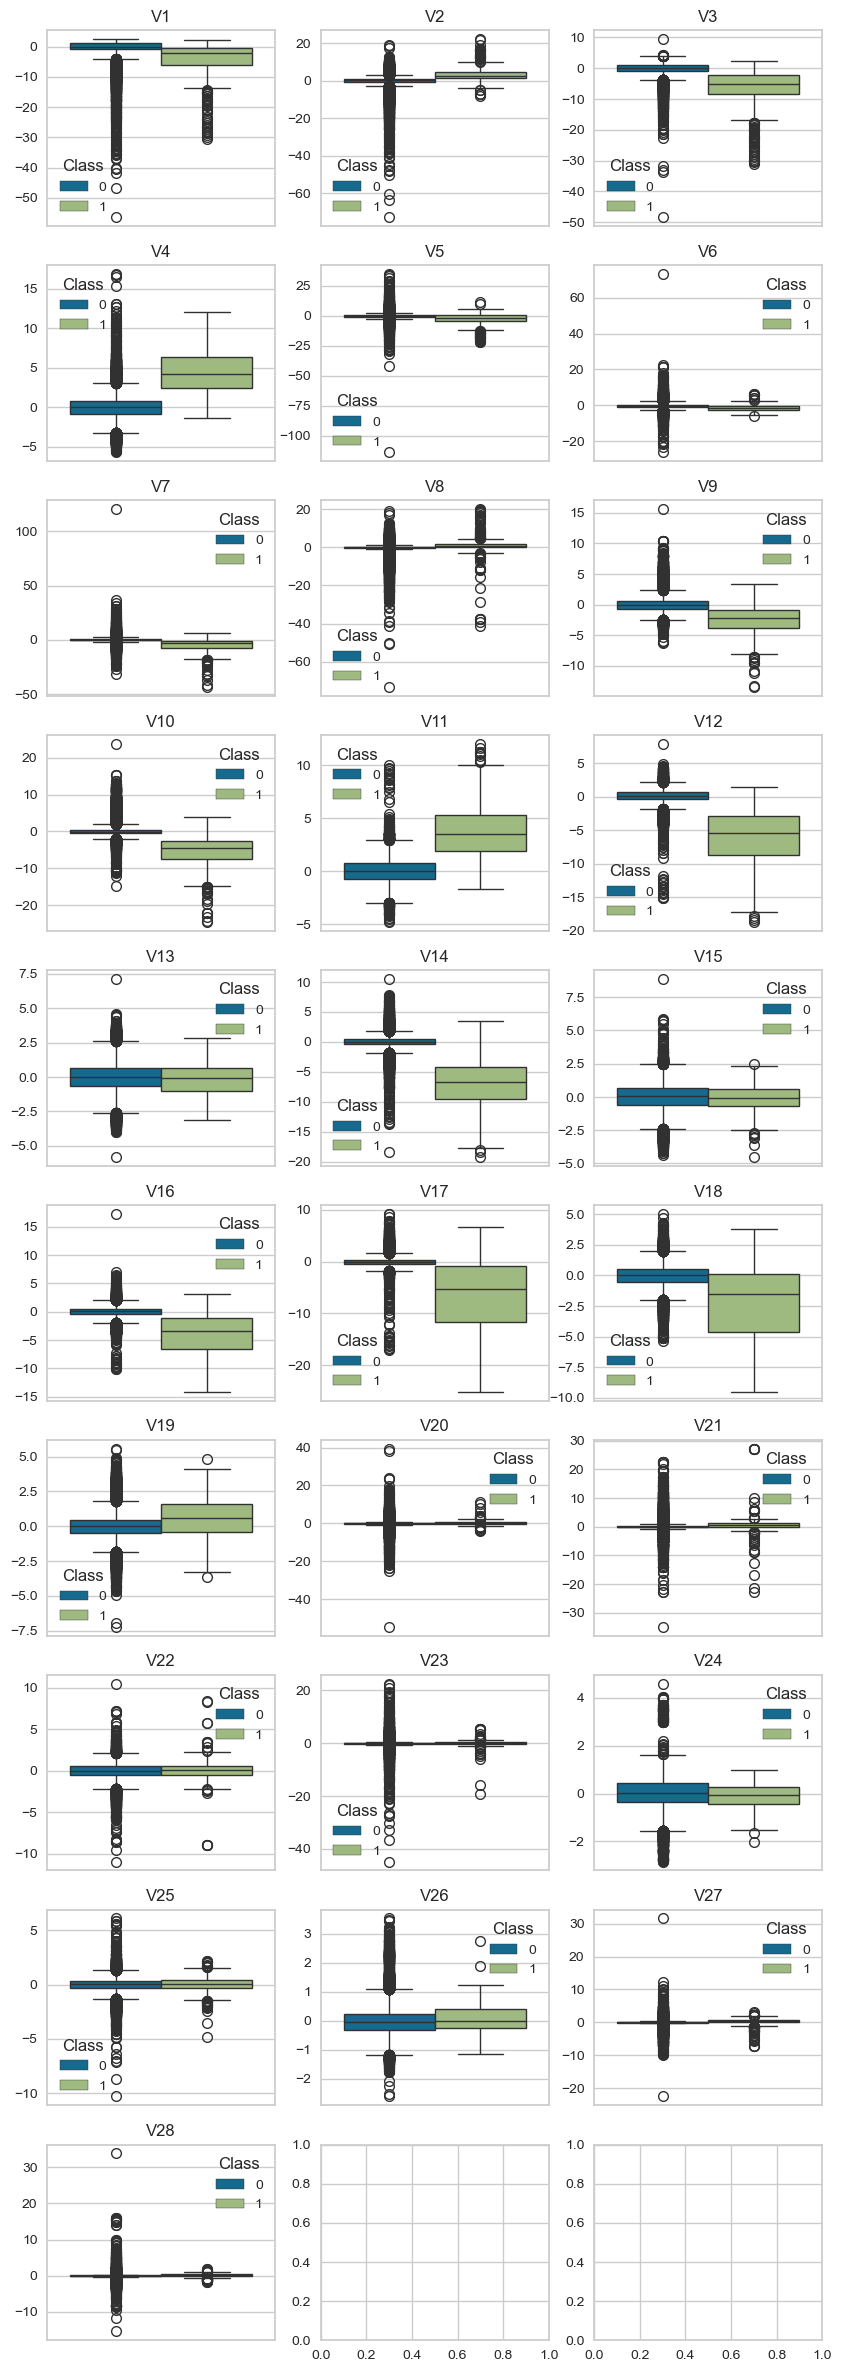

In [13]:
def boxplotV(X_train, colmnsV, cols=3):
    rows = ceil(colmnsV.shape[0] / cols)
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, rows*3))
    axiter = [axj for axi in ax for axj in axi]
    for i, col in enumerate(colmnsV):
        sns.boxplot(X_train, y=col, hue=y_train, ax=axiter[i]);
        axiter[i].set_title(col)
        axiter[i].set_ylabel(None)
    fig.show()
    
colmnsV = X_train.columns[X_train.columns.str.contains("V")]    
boxplotV(X_train, colmnsV)

Очевидно, вибросы есть и по каждому из признаков их немало, попробуем просто удалить их из обучающего набора.

In [14]:
def outliers(X_train, colmnsV, qntf=1.5):
    q1 = X_train[colmnsV].quantile(0.25)
    q3 = X_train[colmnsV].quantile(0.75)
    H = q3-q1
    h = q3 + qntf*H
    l = q1 - qntf*H
    maskV = ((X_train[colmnsV] < h) * (X_train[colmnsV] > l)).all(axis=1)
    return maskV

maskV = outliers(X_train, colmnsV)
X_train_new = X_train[maskV]

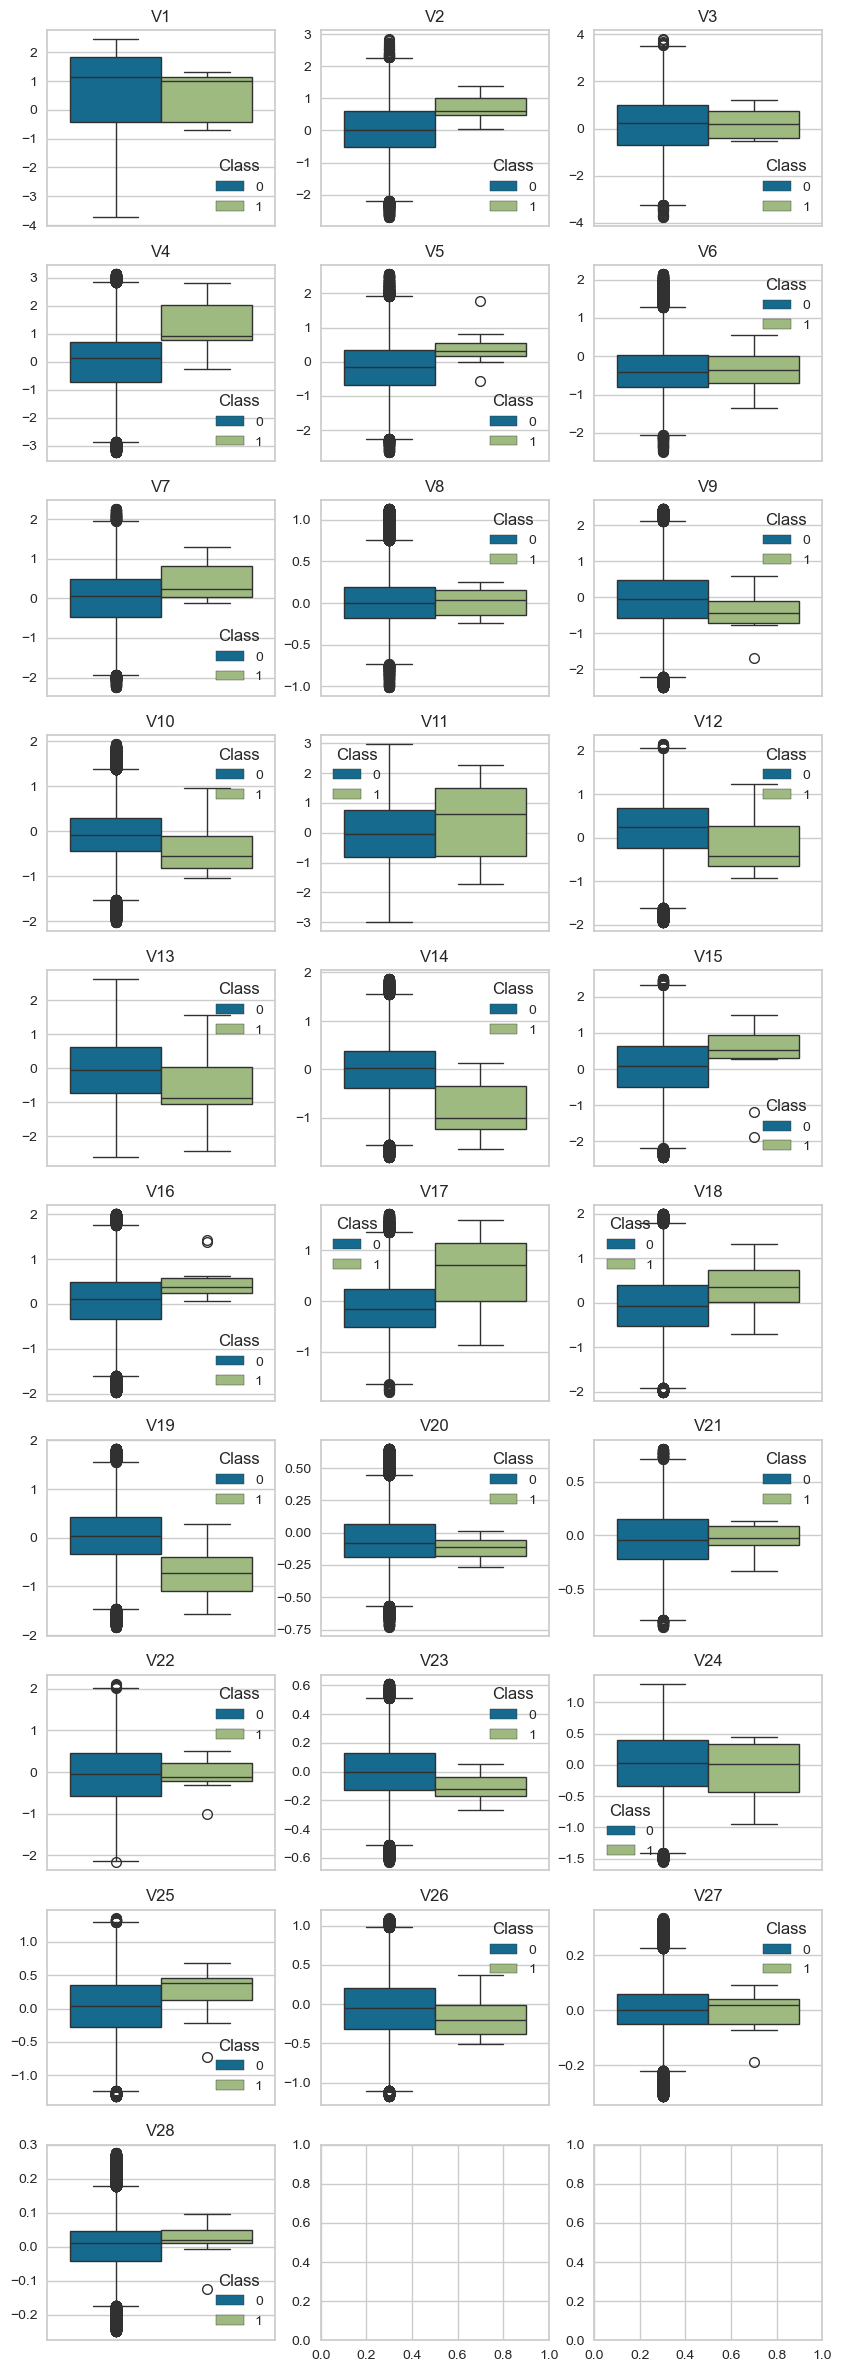

In [15]:
boxplotV(X_train_new, colmnsV)

Теперь ситуация в разы лучше, но чтобы понять, устроит ли такой вариант, необходимо посмотреть на объем данных по каждому классу, не получилось ли так, что и без того малочисленный класс превратился в еще более меньший, нне стало ли данных слишком мало.

In [16]:
def value_counts(y):
    counts = y.value_counts()
    for class_, count_ in counts.items():
        print(f"Класс \"{class_}\" содержит {count_} экземпляров.")
y_train_new = y_train[maskV]
print("Было")
value_counts(y_train)
print("Стало")
value_counts(y_train_new)

Было
Класс "0" содержит 227451 экземпляров.
Класс "1" содержит 394 экземпляров.
Стало
Класс "0" содержит 124911 экземпляров.
Класс "1" содержит 11 экземпляров.


Очевидно, на таком наборе данных хорошо модель не обучить. Теряется большая часть класса-меньшинства, и примерно половина от общего количества экземпляров. Попробуем обрезать только те выбросы, которые составляют не 1.5 межквартильного размаха а 3.

In [17]:
maskV = outliers(X_train, colmnsV, 3)
X_train_new = X_train[maskV]
y_train_new = y_train[maskV]
print("Было")
value_counts(y_train)
print("Стало")
value_counts(y_train_new)

Было
Класс "0" содержит 227451 экземпляров.
Класс "1" содержит 394 экземпляров.
Стало
Класс "0" содержит 193095 экземпляров.
Класс "1" содержит 39 экземпляров.


Опять же ситуация нас не устраивает, поэтому обрежем только выбросы, рассчитанные относительно 0 класса. А также возьмем межквартильный размах равный 3.

In [18]:
maskV = outliers(X_train[y_train==0], colmnsV, 3)
maskV = pd.concat((maskV, y_train[y_train==1] == 1))
X_train_new = X_train[maskV | (y_train==1)]
y_train_new = y_train[maskV | (y_train==1)]
print("Было")
value_counts(y_train)
print("Стало")
value_counts(y_train_new)

Было
Класс "0" содержит 227451 экземпляров.
Класс "1" содержит 394 экземпляров.
Стало
Класс "0" содержит 192977 экземпляров.
Класс "1" содержит 394 экземпляров.


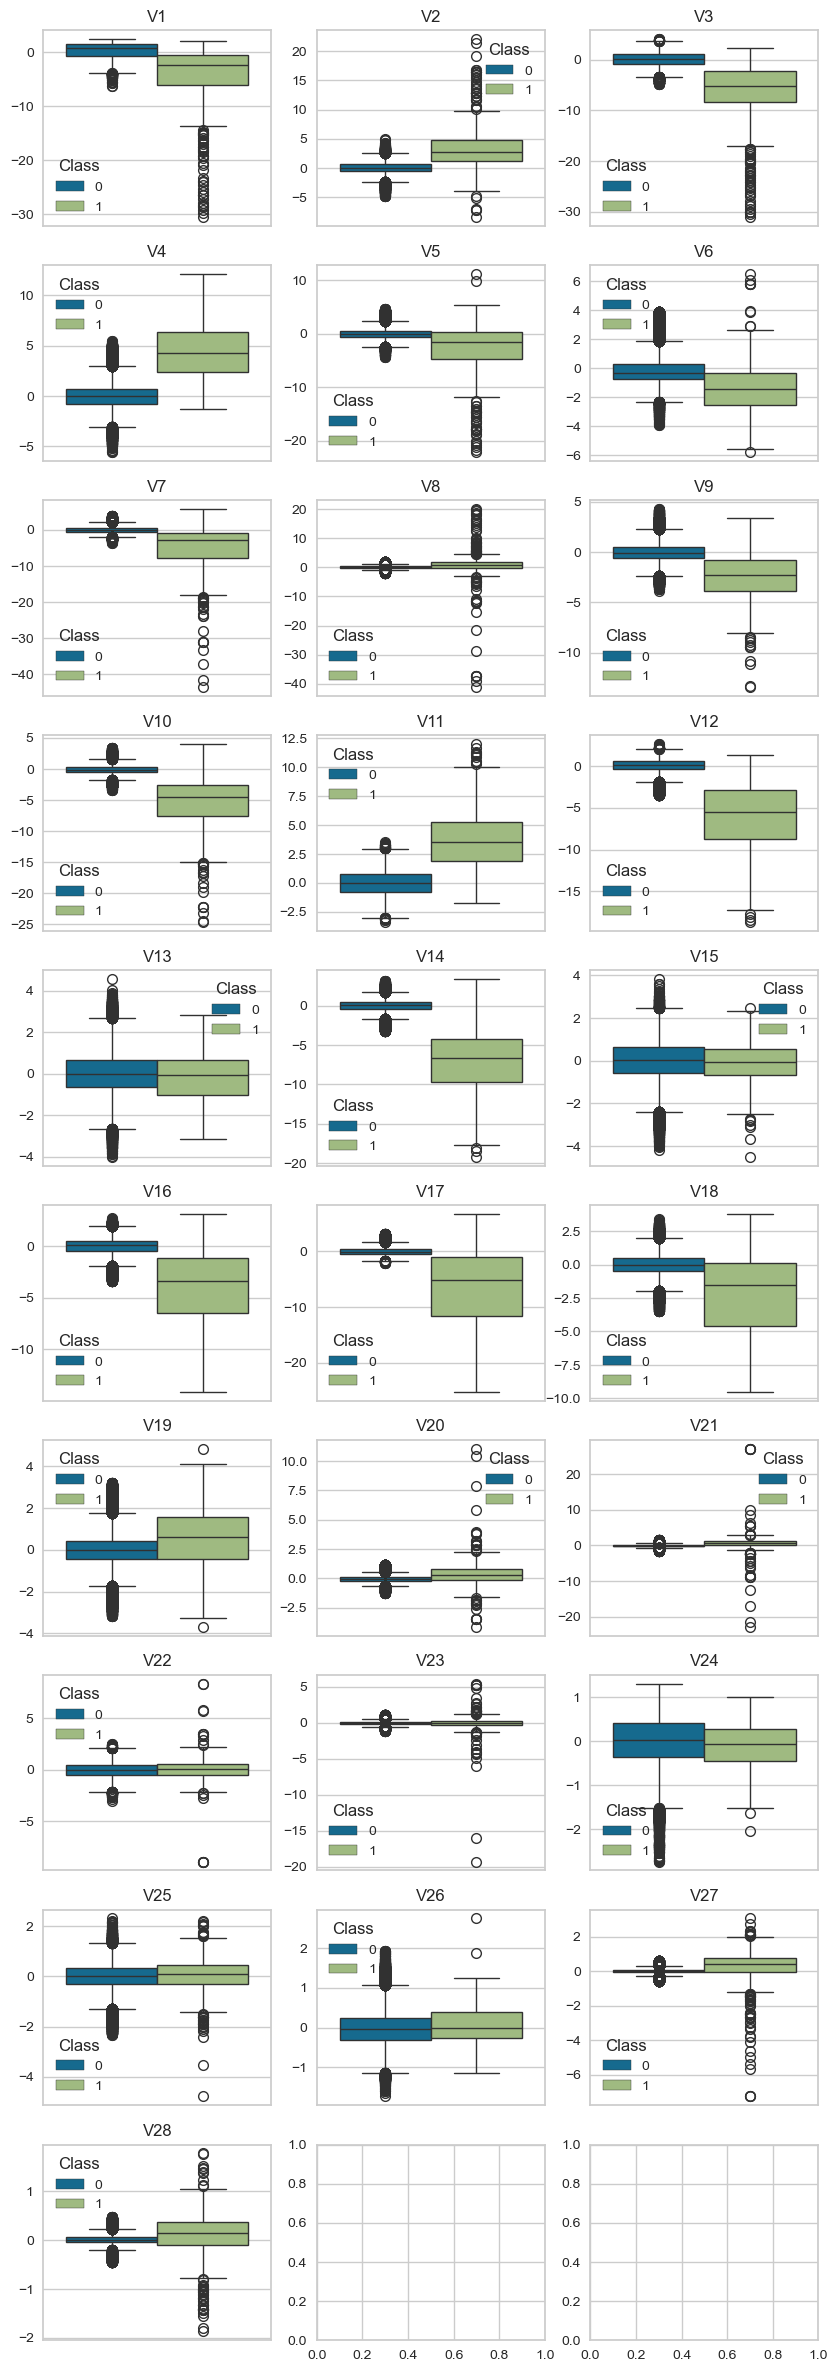

In [19]:
boxplotV(X_train_new, colmnsV)

Без выбросов модель будет меньше путаться, а и без того многочисленный класс лишь немного изменил общий баланс классов.

Проблема выбросов 0 класса играет роль, так как по диаграммам видно, что оба класса по каждому признаку сосредоточены в отдельных диапазонах значений, а так как первого класса достаточно много, то это оказывает влияние на обнаружение моделью зависимостей. Так как 0.5% выбросов 0 класса, которые могут находиться в диапазоне 1 класса уже оказывают существенное значение, так как в 1 класс составляет всего 0.17% от общего объема данных.

In [20]:
print("_________TRAIN__________")
print_balance_stat(y_train_new)

_________TRAIN__________
Не мошеннические операции составляют 99.8 % от всего объема данных
Мошеннические операции составляют 0.2 % от всего объема данных


### Балансировка классов

Существует несколько методов борьбы с несбалансированными данными, некоторые из них:
- Oversampling (SMOTE, ADASYN)
- Undersampling
- Взвешивание классов

Используем некоторые из них и сравним результаты.

Далее сравним полученные метрики по каждому из методов балансировки классов, дополнительно выбрав некоторые наилучшие параметры при помощи GridSearchCV, а также рассчитаем метрики на тестовом множестве. Для преобразований будет использоваться pipline, который обеспечивает применение методов resampling только к тренировочному набору, не затрагивая валидационный (на тренировочный делим при помощи StratifiedKFold), а проверка метрик для сравнения происходит уже на тестовом наборе.

Для этого заново поделим на тренировочный (включающий тренировочный и валидационный) и тестовый наборы, без применения к ним преобразований, все преобразования будут происходить внутри Pipline, что будет более правильным решением.

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
X, y = df.drop(columns="Class"), df.Class
train_index, test_index = next(split.split(X, y))
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_test, y_test = X.iloc[test_index], y.iloc[test_index]
X_train_new, y_train_new = X_train[maskV], y_train[maskV]

In [22]:
classes=["no fraud", "fraud"]

Создание функций для обучения моделей и проверки метрик.

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def refit_strategy(cv_results_):
    columns = ["mean_fit_time", "mean_test_roc_auc"]
    cv_results_df = pd.DataFrame.from_dict(cv_results_)[columns]
    max_roc_auc = cv_results_df.mean_test_roc_auc.max()
    cv_results_df = cv_results_df[np.abs(cv_results_df.mean_test_roc_auc - max_roc_auc)<0.01]
    min_time = cv_results_df.mean_fit_time.min()
    cv_results_df = cv_results_df[cv_results_df.mean_fit_time < min_time*5]
    return cv_results_df.mean_test_roc_auc.idxmax()

def get_best_estimator(estimator, X, y, param_grid, cv, refit, scoring=["roc_auc"]):
    gscv = GridSearchCV(estimator, param_grid=param_grid,
                        cv=cv, scoring=scoring, refit=refit, n_jobs=-1)
    gscv.fit(X, y)
    return gscv

def get_metrics(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    return {
        "accuracy":accuracy_score(y, y_pred),
        "precision":precision_score(y, y_pred),
        "recall":recall_score(y, y_pred),
        "f1":f1_score(y, y_pred),
        "roc_auc":roc_auc_score(y, y_pred_proba),
        "conf_m":confusion_matrix(y, y_pred),
    }

def scoring_for_cv(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    [[tn, fn], [fp, tp]] = confusion_matrix(y, y_pred)
    return {
        "accuracy":accuracy_score(y, y_pred),
        "precision":precision_score(y, y_pred),
        "recall":recall_score(y, y_pred),
        "f1":f1_score(y, y_pred),
        "roc_auc":roc_auc_score(y, y_pred_proba),
        "tn":tn,
        "fn":fn,
        "fp":fp,
        "tp":tp,
    }

def my_cv(estimator, X, y, cv):
    ress = cross_validate(estimator, X, y, cv=cv, scoring=scoring_for_cv, n_jobs=-1)
    for k, v in ress.items():
        ress[k] = v.mean()
    return {
        "accuracy":ress["test_accuracy"],
        "precision":ress["test_precision"],
        "recall":ress["test_recall"],
        "f1":ress["test_f1"],
        "roc_auc":ress["test_roc_auc"],
        "conf_m":[[round(ress["test_tn"]), round(ress["test_fn"])],
                  [round(ress["test_fp"]), round(ress["test_tp"])]],
    }

def show_learning_curve(estimator, X, y, cv, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), sharey=True)
    LearningCurveDisplay.from_estimator(
        estimator, X=X, y=y, ax=ax,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring="roc_auc",
        cv=cv, score_type="both",
        line_kw={"marker": "o"},
        std_display_style="fill_between",
        score_name="ROC AUC",
        n_jobs=-1,
        shuffle=True,
    )
    ax.set_title(title)
    fig.show()

def test_model(estimator, X_train, y_train, X_test, y_test, param_grid, cv, refit, name):
    best_estim = get_best_estimator(estimator, X_train, y_train, param_grid, cv, refit)
    best_estim = best_estim.best_estimator_
    metrics = get_metrics(best_estim, X_test, y_test)
    show_learning_curve(best_estim, X_train, y_train, cv, title=name)
    return best_estim, metrics

def add_metrics(metrics, model, name, outliers, transform, df=None):
    new_str = pd.DataFrame(
        columns=["name", "model", "outliers", "transform",
                 "accuracy", "precision", "recall", "f1", "roc_auc", "conf_m"],
        data=[[
            name, model, outliers, transform, metrics["accuracy"],
            metrics["precision"], metrics["recall"],
            metrics["f1"], metrics["roc_auc"], metrics["conf_m"],
        ]]
    )
    if df is None:
        return new_str
    else:
        return pd.concat((df, new_str), ignore_index=True, axis=0)
    
def heatmap(conf_m):
    plt.figure(figsize=(3,2))
    sns.heatmap(conf_m, annot=True, cmap="Greens",
                fmt="d", xticklabels=classes, yticklabels=classes)
    plt.show()

Далее будет использовано два метода балансировки классов и также тест без балансировки классов:
- oversampling(SMOTE)
- class weights
- original data

Undersampling не будет использован, так как класса "1" очень мало и модель не сможет обучится на столь небольшом наборе данных, относительно исходного (с 200+ тысяч элементов обрежется до чуть меньше чем 1 тысячи)

1. LogisticRegression

- LogisticRegression (original data)

In [24]:
preprocessor = make_column_transformer(
    (StandardScaler(), ["Time"]),
    (RobustScaler(), ["Amount"]),
    ("passthrough", colmnsV)
)

In [25]:
estimator = LogisticRegression()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)
param_grid = {
    namel+"__solver": ["lbfgs", "liblinear", "newton-cholesky"],
    namel+"__C": [0.01, 0.1, 1, 10, 100],
}

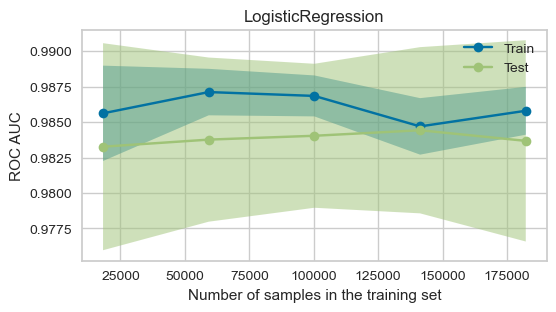

In [26]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [27]:
results = add_metrics(metrics, best_estim, name,"with outliers", "original")
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"


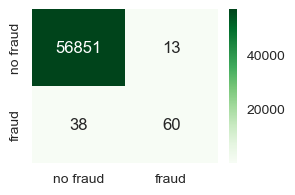

In [28]:
heatmap(metrics["conf_m"])

Теперь проверим эту же модель, но на наборе с удаленными выбросами

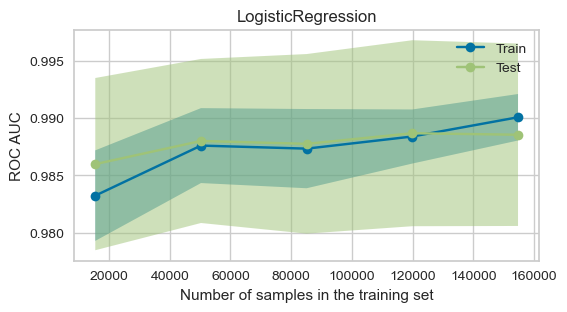

In [29]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [30]:
results = add_metrics(metrics, best_estim, name,"witout outliers", "original", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"


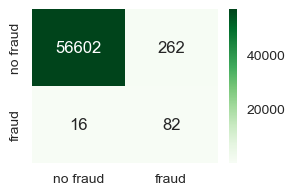

In [31]:
heatmap(metrics["conf_m"])

Модель стала лучше определять положительный класс, что является нашей целью. Но также она больше путается и с отрицательным классом.

- LogisticRegression (SMOTE)

In [32]:
estimator = LogisticRegression()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)
param_grid = {
    namel+"__solver": ["lbfgs", "liblinear", "newton-cholesky"],
    namel+"__C": [0.01, 0.1, 1, 10, 100],
}

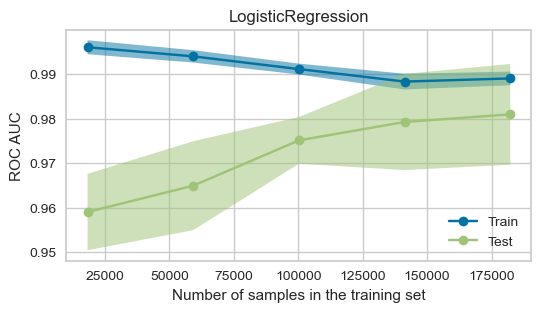

In [33]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [34]:
results = add_metrics(metrics, best_estim, name, "with outliers", "SMOTE", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"


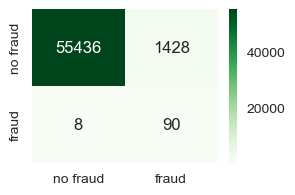

In [35]:
heatmap(metrics["conf_m"])

А теперь без выбросов.

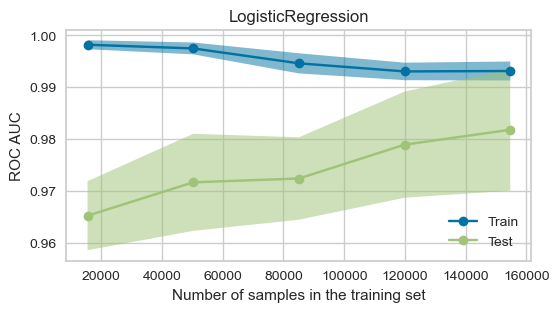

In [36]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [37]:
results = add_metrics(metrics, best_estim, name, "witout outliers", "SMOTE", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"


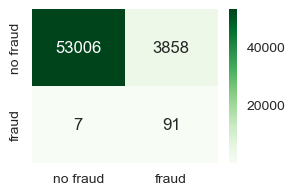

In [38]:
heatmap(metrics["conf_m"])

Здесь наблюдается похожая картина, только модель обучилась на 1 класс совсем немного лучше, чем с выбросами, зато вот ошибаться в 0 классе стала в два раза больше. Этот результат уже не назовешь удовлетворительным, тем более целевая метрика ROC AUC упала по сравнению с предыдущим случаем.

- LogisticRegression (class weights)

In [25]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [40]:
estimator = LogisticRegression()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)
param_grid = {
    namel+"__solver": ["lbfgs", "liblinear", "newton-cholesky"],
    namel+"__C": [0.01, 0.1, 1, 10, 100],
    namel+"__class_weight": [class_weights],
}

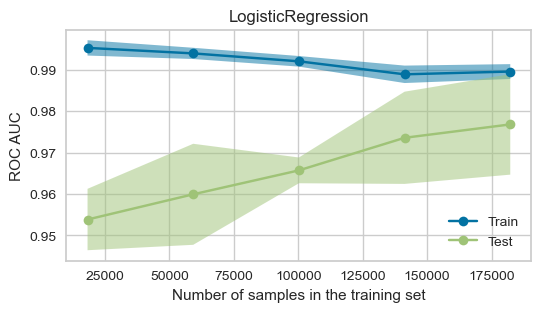

In [41]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [42]:
results = add_metrics(metrics, best_estim, name, "with outliers", "class weights", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"


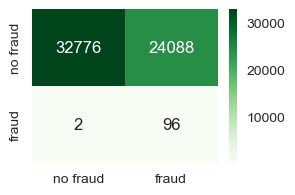

In [43]:
heatmap(metrics["conf_m"])

Теперь то же самое но без выбросов.

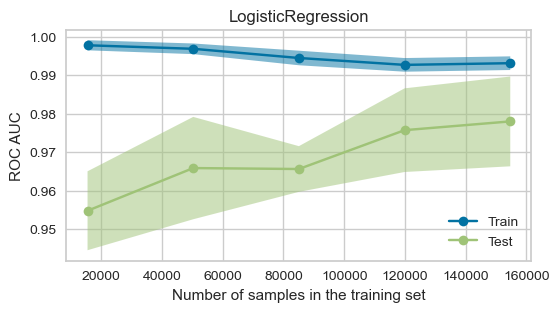

In [44]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [45]:
results = add_metrics(metrics, best_estim, name, "without outliers", "class weights", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"


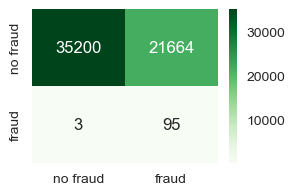

In [46]:
heatmap(metrics["conf_m"])

Взвешивание классов дало хороший результат по 1 классу, но совершенно неприемлемый по 0. Этот вариант сразу исключаем.

2. SVC

- SVC (original data)

In [47]:
estimator = SVC()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)
param_grid = {
    namel+"__kernel": ["linear", "rbf"],
    namel+"__C": [0.01, 0.1, 1],
    namel+"__probability": [True],
}

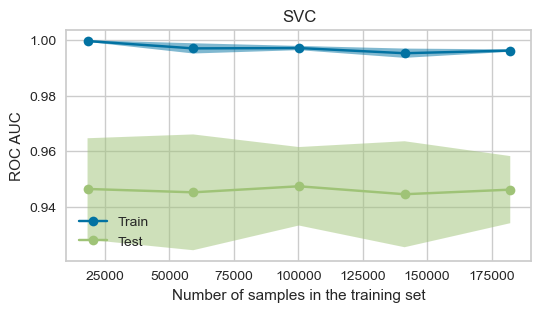

In [48]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [49]:
results = add_metrics(metrics, best_estim, name, "with outliers", "original", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"


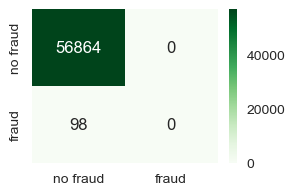

In [50]:
heatmap(metrics["conf_m"])

На датасете без выбросов.

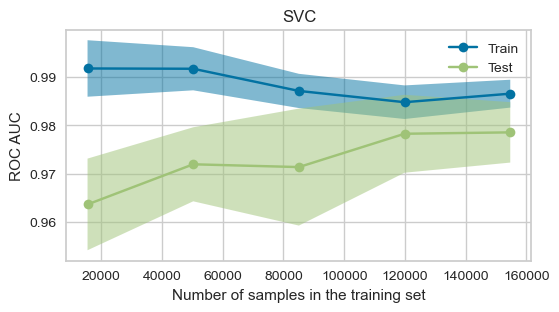

In [51]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [52]:
results = add_metrics(metrics, best_estim, name, "without outliers", "original", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"


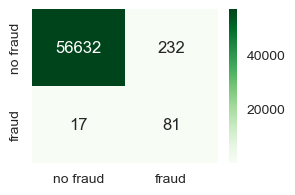

In [53]:
heatmap(metrics["conf_m"])

- SVC (SMOTE)

Поиск по сетке требует очень больших ресурсов, тем более при увеличении набора данных с помощью SMOTE, поэтому следующая часть будет выполнена без GRID_SEARCH. Также, опыт показывает, что идеальные параметры не меняются от модели к модели (почти).

Выведем параметры на экран.

In [54]:
for model in results.model:
    print(model[-1])

LogisticRegression(C=0.01, solver='newton-cholesky')
LogisticRegression(C=0.01, solver='newton-cholesky')
LogisticRegression(C=0.01, solver='liblinear')
LogisticRegression(C=0.01, solver='liblinear')
LogisticRegression(C=0.01,
                   class_weight={0: 0.5008661206149896, 1: 289.14340101522845},
                   solver='newton-cholesky')
LogisticRegression(C=0.01,
                   class_weight={0: 0.5008661206149896, 1: 289.14340101522845},
                   solver='newton-cholesky')
SVC(C=0.01, probability=True)
SVC(C=1, kernel='linear', probability=True)


In [55]:
estimator = SVC(probability=True, C=0.01, max_iter=10000)
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)

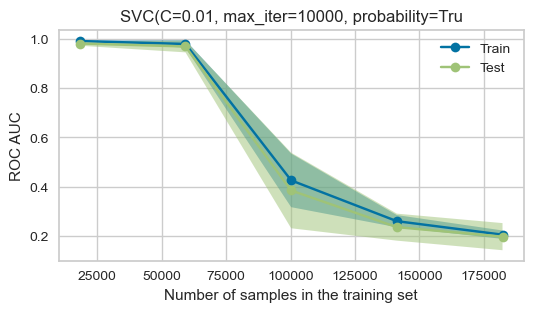

In [56]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

Видно, что модель хорошо обучается на небольшом наборе данных, дальше ей необходимо очень большое число итераций (выборка увеличивается почти в 2 раза за счет SMOTE), что занимает много времени, поэтому сократим объем выборки.

In [26]:
cut_id = np.random.choice(y_train[y_train == 0].index, int(y_train.shape[0]*0.1), replace=False)
cut_id = np.concatenate((cut_id, y_train[y_train==1].index))
y_train_cut = y_train[cut_id]
X_train_cut = X_train.loc[cut_id]
value_counts(y_train_cut)
print_balance_stat(y_train_cut)

Класс "0" содержит 22784 экземпляров.
Класс "1" содержит 394 экземпляров.
Не мошеннические операции составляют 98.3 % от всего объема данных
Мошеннические операции составляют 1.7 % от всего объема данных


То же самое для выборки без выбросов.

In [27]:
cut_id_new = np.random.choice(y_train_new[y_train_new == 0].index, int(y_train_new.shape[0]*0.1), replace=False)
cut_id_new = np.concatenate((cut_id_new, y_train_new[y_train_new==1].index))
y_train_new_cut = y_train_new[cut_id_new]
X_train_new_cut = X_train_new.loc[cut_id_new]
value_counts(y_train_new_cut)
print_balance_stat(y_train_new_cut)

Класс "0" содержит 19337 экземпляров.
Класс "1" содержит 394 экземпляров.
Не мошеннические операции составляют 98.0 % от всего объема данных
Мошеннические операции составляют 2.0 % от всего объема данных


Прогоним заново и посмотрим результаты.

In [74]:
estimator = SVC()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)
param_grid = {
    namel+"__kernel": ["linear", "rbf"],
    namel+"__C": [0.01, 0.1, 1],
    namel+"__probability": [True],
}

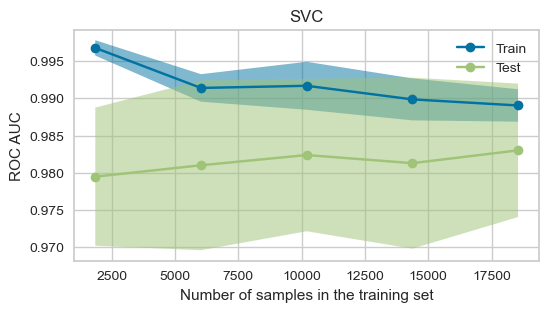

In [77]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_cut, y_train_cut, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [78]:
results = add_metrics(metrics, best_estim, name, "with outliers", "SMOTE", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"


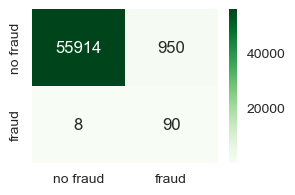

In [79]:
heatmap(metrics["conf_m"])

Далее вариант без выбросов.

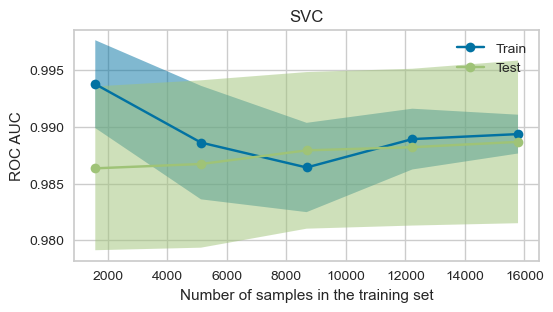

In [80]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new_cut, y_train_new_cut, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [81]:
results = add_metrics(metrics, best_estim, name, "without outliers", "SMOTE", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


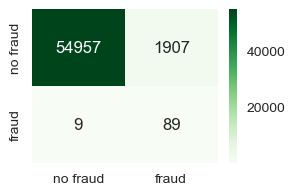

In [82]:
heatmap(metrics["conf_m"])

- SVC (class weights)

In [28]:
class_weights_cut = compute_class_weight('balanced', classes=np.unique(y_train_cut), y=y_train_cut)
class_weights_cut = dict(enumerate(class_weights_cut))

In [150]:
estimator = SVC()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)
param_grid = {
    namel+"__kernel": ["linear", "rbf"],
    namel+"__C": [0.01, 0.1, 1],
    namel+"__probability": [True],
    namel+"__class_weight": [class_weights_cut],
}

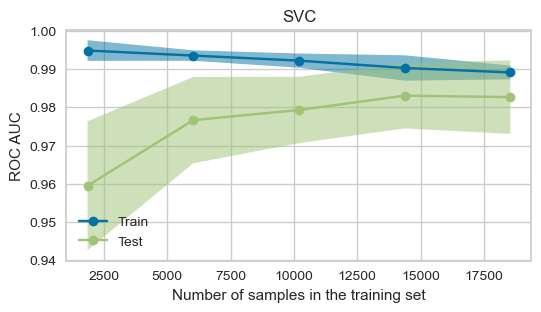

In [151]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_cut, y_train_cut, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [159]:
results = add_metrics(metrics, best_estim, name, "with outliers", "class weights", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


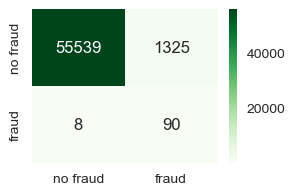

In [160]:
heatmap(metrics["conf_m"])

С очищенными выбросами.

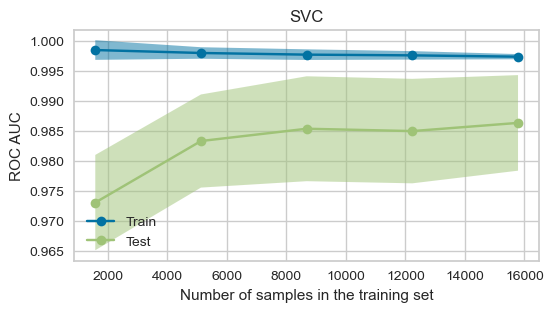

In [161]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new_cut, y_train_new_cut, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [167]:
results = add_metrics(metrics, best_estim, name, "without outliers", "class weights", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


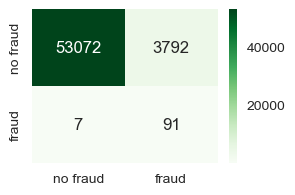

In [163]:
heatmap(metrics["conf_m"])

Из всех моделей можно выделить SMOTE на данных с выбросами. Она показала наилучший результат.

Также можно заметить, что взвешивание классов дает весьма неудовлетворительный результат, либо нужно пересмотреть порог принятия решений (мы выбираем класс при вероятности более 50%), возможно, если его снизить (для 1 класса), то матрица ошибок будет иметь иной вид, тогда как roc_auc слабо отличается от остальных моделей.

3. KNeighborsClassifier

- KNeighborsClassifier (original data)

In [106]:
estimator = KNeighborsClassifier()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)
param_grid = {
    namel+"__n_neighbors": [5,10,15,20,30,40,50],
    namel+"__n_jobs": [-1],
    namel+"__weights": ["uniform", "distance"],
}

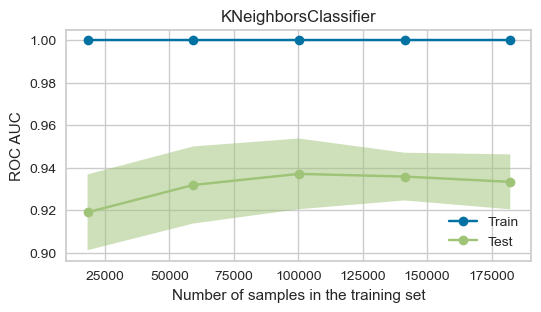

In [107]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [108]:
results = add_metrics(metrics, best_estim, name, "with outliers", "original", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


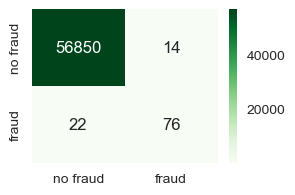

In [109]:
heatmap(metrics["conf_m"])

Без выбросов.

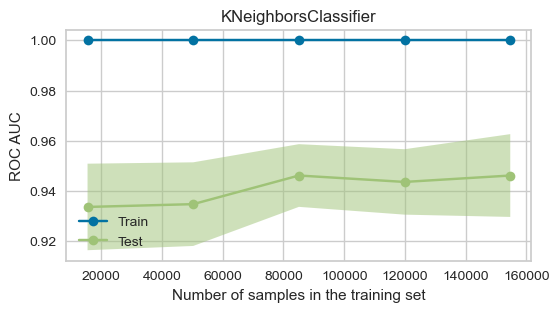

In [110]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [111]:
results = add_metrics(metrics, best_estim, name, "without outliers", "original", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


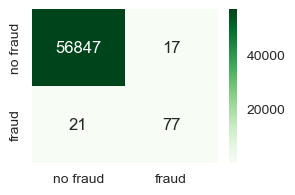

In [112]:
heatmap(metrics["conf_m"])

- KNeighborsClassifier (SMOTE)

In [114]:
estimator = KNeighborsClassifier()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)
param_grid = {
    namel+"__n_neighbors": [5,10,15,20,30,40,50],
    namel+"__n_jobs": [-1],
    namel+"__weights": ["uniform", "distance"],
}

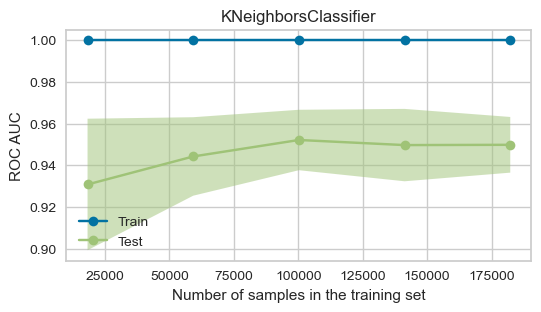

In [115]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [116]:
results = add_metrics(metrics, best_estim, name, "with outliers", "SMOTE", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


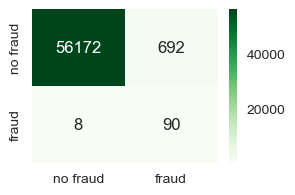

In [117]:
heatmap(metrics["conf_m"])

Без выбросов.

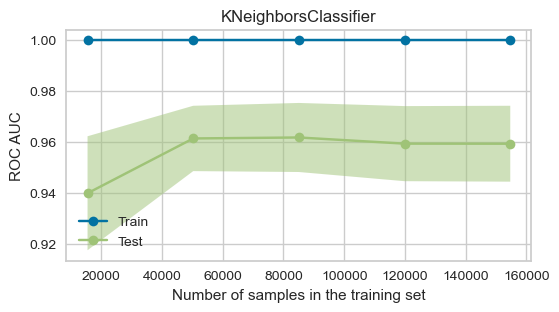

In [118]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [119]:
results = add_metrics(metrics, best_estim, name, "without outliers", "SMOTE", results)
results

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
0,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972423,"[[56851, 13], [38, 60]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"
2,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.974790,0.059289,0.918367,0.111386,0.972235,"[[55436, 1428], [8, 90]]"
3,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,SMOTE,0.932148,0.023044,0.928571,0.044972,0.975332,"[[53006, 3858], [7, 91]]"
4,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.577086,0.003970,0.979592,0.007907,0.973915,"[[32776, 24088], [2, 96]]"
5,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.619624,0.004366,0.969388,0.008693,0.973418,"[[35200, 21664], [3, 95]]"
6,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998280,0.000000,0.000000,0.000000,0.964920,"[[56864, 0], [98, 0]]"
7,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995629,0.258786,0.826531,0.394161,0.962544,"[[56632, 232], [17, 81]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
9,SVC,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.966364,0.044589,0.908163,0.085005,0.976860,"[[54957, 1907], [9, 89]]"


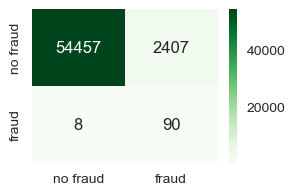

In [120]:
heatmap(metrics["conf_m"])

4. DecisionTreeClassifier

- DecisionTreeClassifier (original data)

In [125]:
estimator = DecisionTreeClassifier()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)
param_grid = {
    namel+"__criterion": ["gini", "entropy", "log_loss"],
}

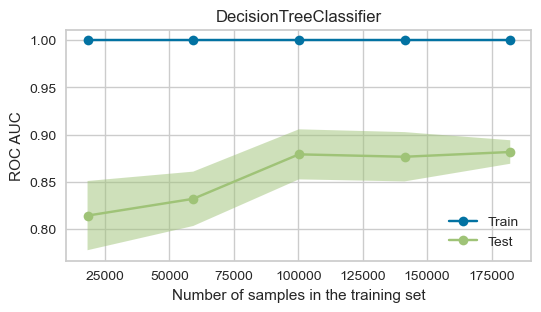

In [126]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [130]:
results = add_metrics(metrics, best_estim, name, "with outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
16,DecisionTreeClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999315,0.780952,0.836735,0.807882,0.918165,"[[56841, 23], [16, 82]]"


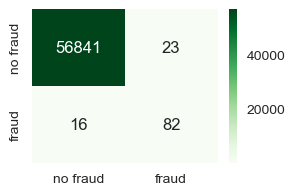

In [128]:
heatmap(metrics["conf_m"])

Без выбросов.

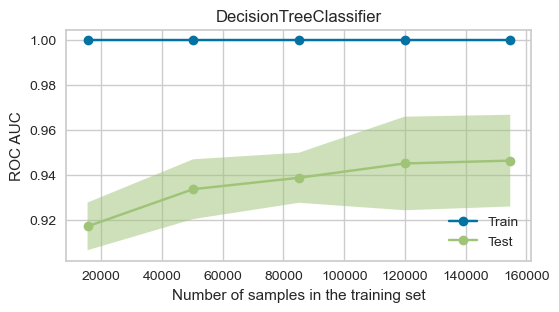

In [131]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [132]:
results = add_metrics(metrics, best_estim, name, "without outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
17,DecisionTreeClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.932183,0.022814,0.918367,0.044521,0.925287,"[[53009, 3855], [8, 90]]"


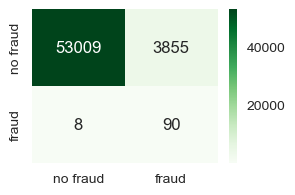

In [133]:
heatmap(metrics["conf_m"])

- DecisionTreeClassifier (SMOTE)

In [134]:
estimator = DecisionTreeClassifier()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)
param_grid = {
    namel+"__criterion": ["gini", "entropy", "log_loss"],
}

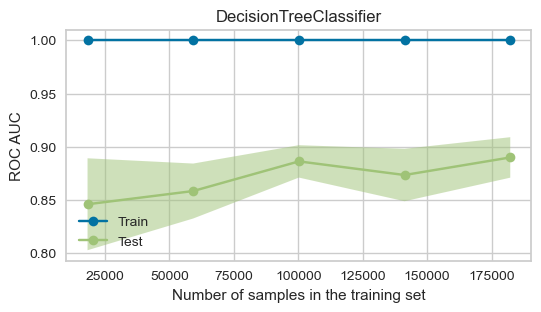

In [135]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [136]:
results = add_metrics(metrics, best_estim, name, "with outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
18,DecisionTreeClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.997402,0.380952,0.816327,0.519481,0.90702,"[[56734, 130], [18, 80]]"


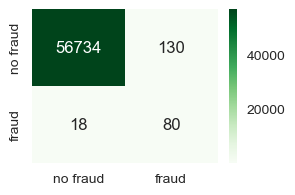

In [137]:
heatmap(metrics["conf_m"])

Без выбросов.

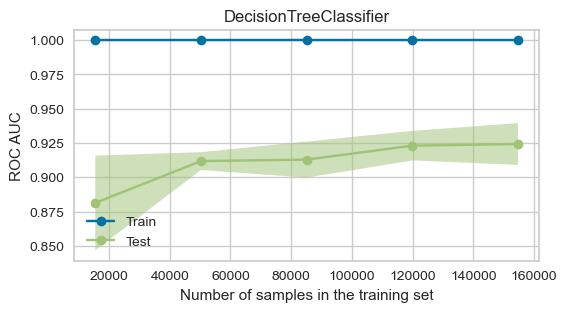

In [138]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [139]:
results = add_metrics(metrics, best_estim, name, "without outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
19,DecisionTreeClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.981216,0.074431,0.867347,0.137097,0.924379,"[[55807, 1057], [13, 85]]"


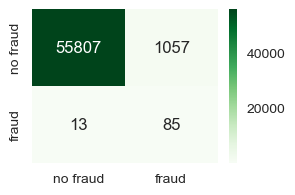

In [140]:
heatmap(metrics["conf_m"])

- DecisionTreeClassifier (class weights)

In [141]:
estimator = DecisionTreeClassifier()
name = str(estimator)[:-2]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)
param_grid = {
    namel+"__criterion": ["gini", "entropy", "log_loss"],
    namel+"__class_weight": [class_weights],
}

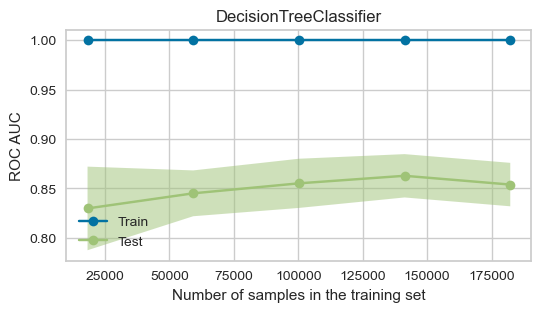

In [142]:
best_estim, metrics = test_model(
    imba_pipeline, X_train, y_train, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [143]:
results = add_metrics(metrics, best_estim, name, "with outliers", "class weights", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
20,DecisionTreeClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.999192,0.76,0.77551,0.767677,0.887544,"[[56840, 24], [22, 76]]"


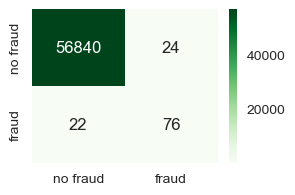

In [144]:
heatmap(metrics["conf_m"])

Без выбросов.

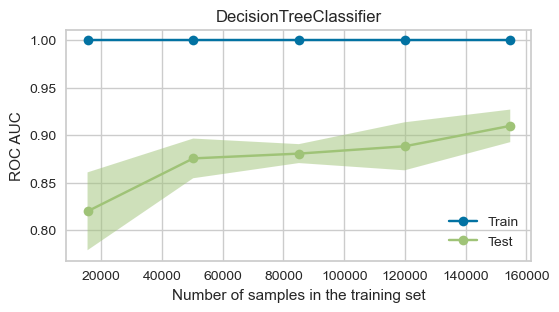

In [145]:
best_estim, metrics = test_model(
    imba_pipeline, X_train_new, y_train_new, X_test, y_test,
    param_grid, skf, refit_strategy, name
)

In [146]:
results = add_metrics(metrics, best_estim, name, "without outliers", "class weights", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
21,DecisionTreeClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.982076,0.076994,0.857143,0.141295,0.919717,"[[55857, 1007], [14, 84]]"


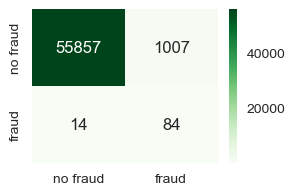

In [147]:
heatmap(metrics["conf_m"])

5. Stacking

- Stacking (original data)

In [245]:
estimators = [
    ('lr', LogisticRegression(C=0.01, solver='newton-cholesky')),
    ('dt', DecisionTreeClassifier(criterion='entropy'))
]
estimator = StackingClassifier(
    estimators=estimators, n_jobs=-1, cv=5,
    final_estimator=KNeighborsClassifier(
        n_jobs=-1, n_neighbors=20, weights='distance')
)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)

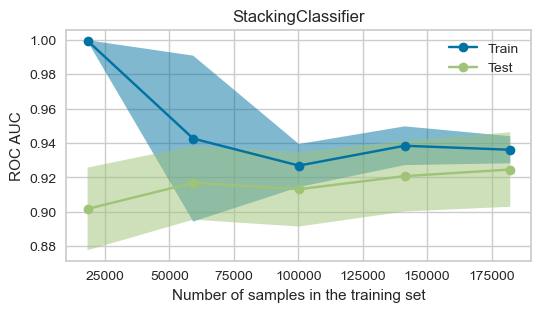

In [246]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [248]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
22,StackingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999438,0.875,0.785714,0.827957,0.943349,"[[56853, 11], [21, 77]]"


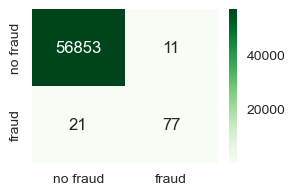

In [249]:
heatmap(metrics["conf_m"])

На наборе без выбросов.

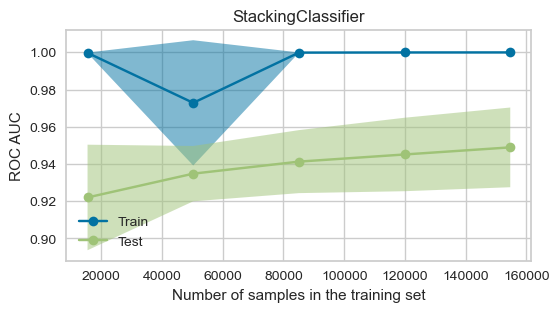

In [250]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [251]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
23,StackingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.976598,0.061746,0.887755,0.115461,0.953258,"[[55542, 1322], [11, 87]]"


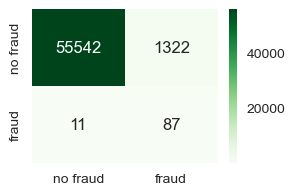

In [252]:
heatmap(metrics["conf_m"])

- Stacking (SMOTE)

In [253]:
estimators = [
    ('lr', LogisticRegression(C=0.01, solver='newton-cholesky')),
    ('dt', DecisionTreeClassifier(criterion='entropy'))
]
estimator = StackingClassifier(
    estimators=estimators, n_jobs=-1, cv=5,
    final_estimator=KNeighborsClassifier(
        n_jobs=-1, n_neighbors=20, weights='distance')
)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)

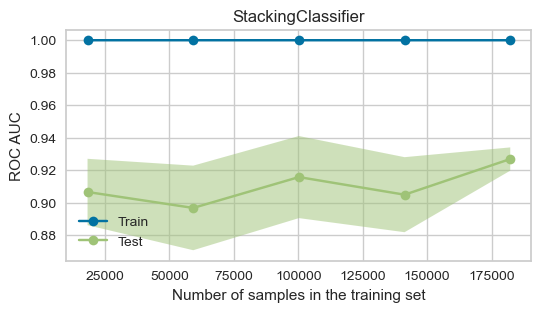

In [254]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [255]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
24,StackingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.997384,0.380282,0.826531,0.5209,0.952068,"[[56732, 132], [17, 81]]"


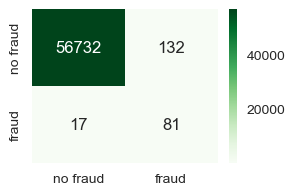

In [256]:
heatmap(metrics["conf_m"])

Без выбросов.

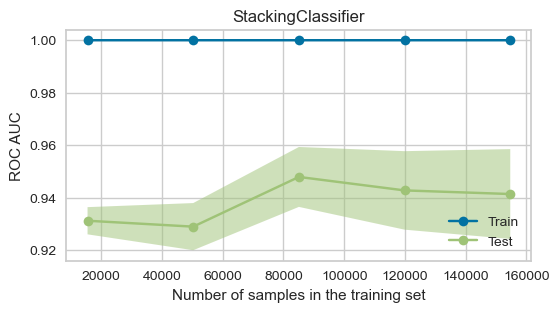

In [257]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [258]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
25,StackingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.974176,0.056238,0.887755,0.105775,0.949473,"[[55404, 1460], [11, 87]]"


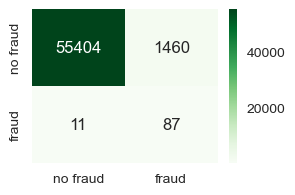

In [259]:
heatmap(metrics["conf_m"])

6. Bagging

- Bagging (original data)

In [267]:
estimator = BaggingClassifier(
    base_estimator=LogisticRegression(C=0.01, solver='newton-cholesky'),
    n_estimators=50, random_state=12, n_jobs=-1)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)

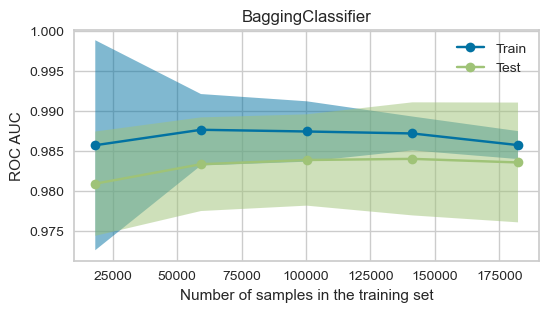

In [268]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [270]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
26,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999105,0.821918,0.612245,0.701754,0.972654,"[[56851, 13], [38, 60]]"


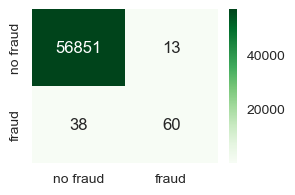

In [271]:
heatmap(metrics["conf_m"])

Без выбросов.

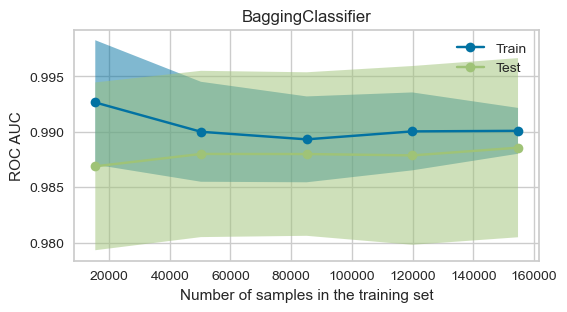

In [272]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [273]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
27,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995242,0.243323,0.836735,0.377011,0.977153,"[[56609, 255], [16, 82]]"


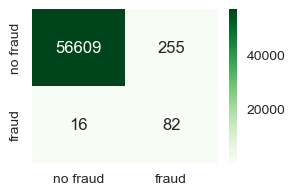

In [274]:
heatmap(metrics["conf_m"])

- Bagging (SMOTE)

In [276]:
estimator = BaggingClassifier(
    base_estimator=LogisticRegression(C=0.01, solver='liblinear'),
    n_estimators=50, random_state=12, n_jobs=-1)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)

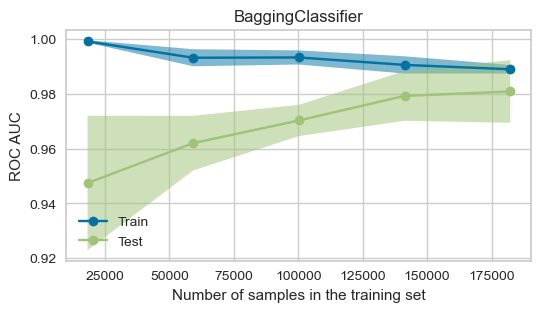

In [277]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [278]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
28,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.97486,0.059445,0.918367,0.111663,0.972139,"[[55440, 1424], [8, 90]]"


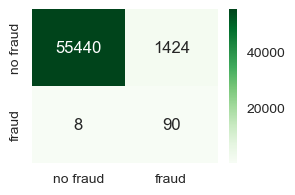

In [279]:
heatmap(metrics["conf_m"])

Без выбросов.

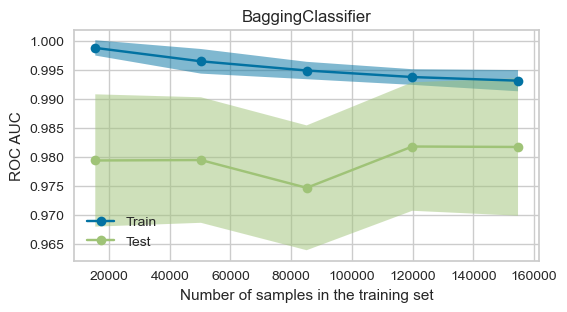

In [280]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [281]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
29,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.932306,0.023096,0.928571,0.045072,0.975305,"[[53015, 3849], [7, 91]]"


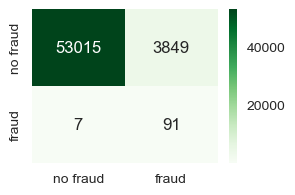

In [282]:
heatmap(metrics["conf_m"])

7. AdaBoost

- AdaBoost (original data)

In [289]:
estimator = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(criterion='entropy'),
    n_estimators=50, random_state=12)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)

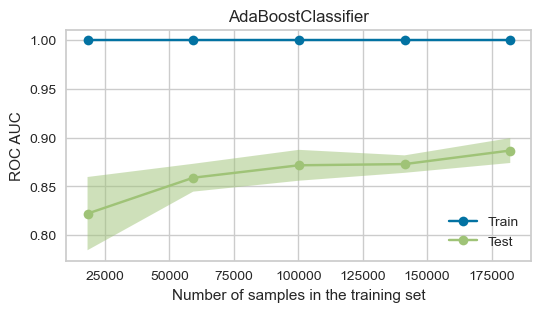

In [290]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [291]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
30,AdaBoostClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999298,0.773585,0.836735,0.803922,0.918156,"[[56840, 24], [16, 82]]"


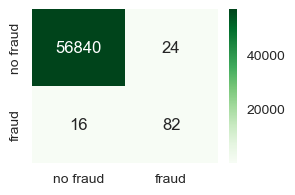

In [292]:
heatmap(metrics["conf_m"])

Без выбросов

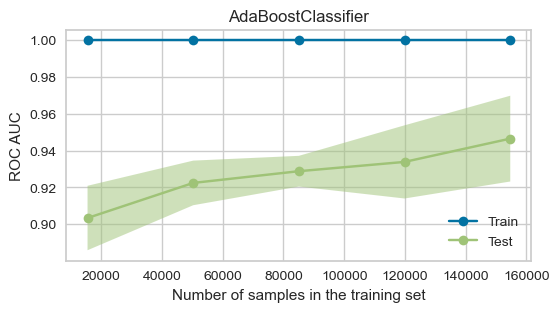

In [293]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [294]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
31,AdaBoostClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.93213,0.022796,0.918367,0.044488,0.925261,"[[53006, 3858], [8, 90]]"


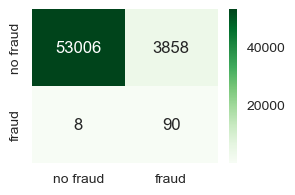

In [295]:
heatmap(metrics["conf_m"])

- AdaBoost (SMOTE)

In [296]:
estimator = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(criterion='entropy'),
    n_estimators=50, random_state=12)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)

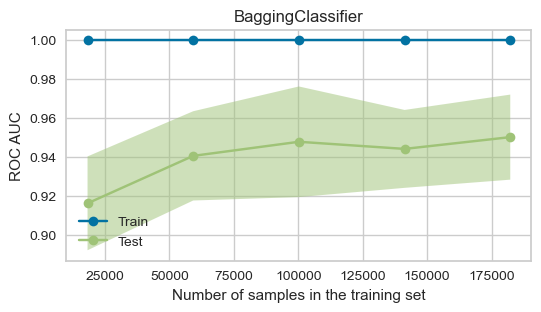

In [297]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [298]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
32,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.999052,0.680328,0.846939,0.754545,0.952031,"[[56825, 39], [15, 83]]"


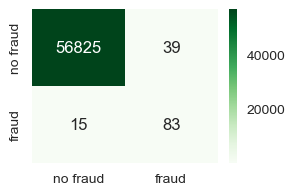

In [299]:
heatmap(metrics["conf_m"])

Без выбросов.

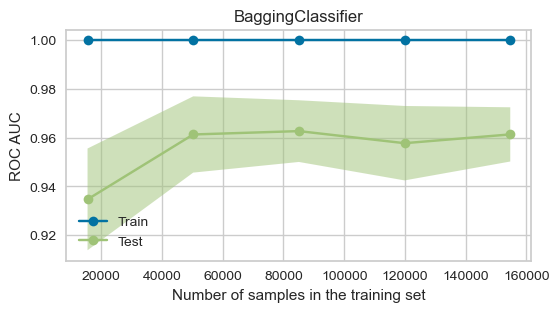

In [300]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [301]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
33,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.983287,0.083008,0.867347,0.151515,0.954966,"[[55925, 939], [13, 85]]"


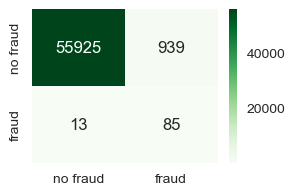

In [302]:
heatmap(metrics["conf_m"])

8. GradientBoosting

- GradientBoosting (original data)

In [31]:
estimator = GradientBoostingClassifier(max_depth=2, n_estimators=150,
                                      random_state=12, learning_rate=1)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    estimator)

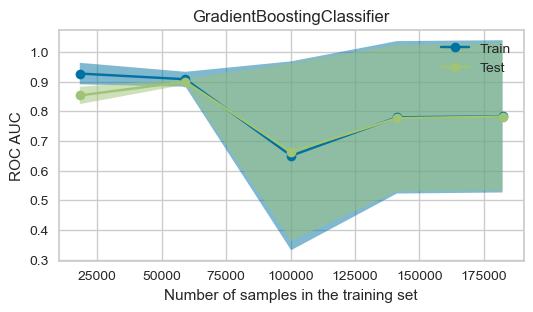

In [32]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [33]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
34,GradientBoostingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.998473,0.535032,0.857143,0.658824,0.927943,"[[56791, 73], [14, 84]]"


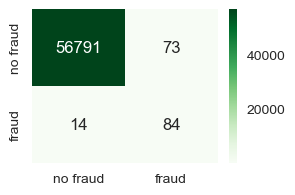

In [34]:
heatmap(metrics["conf_m"])

Без выбросов.

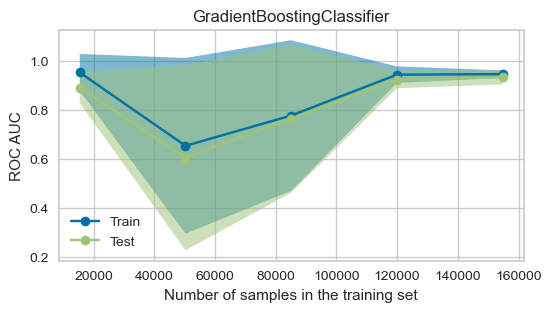

In [35]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [36]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
35,GradientBoostingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.930515,0.021804,0.897959,0.042574,0.914239,"[[52916, 3948], [10, 88]]"


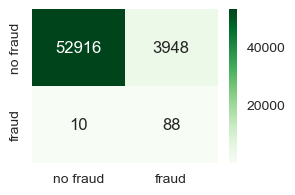

In [37]:
heatmap(metrics["conf_m"])

- GradientBoosting (SMOTE)

In [38]:
estimator = GradientBoostingClassifier(max_depth=2, n_estimators=150,
                                      random_state=12, learning_rate=1)
name = re.search("(\w*)\(", str(estimator)).group()[:-1]
namel = name.lower()
imba_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    estimator)

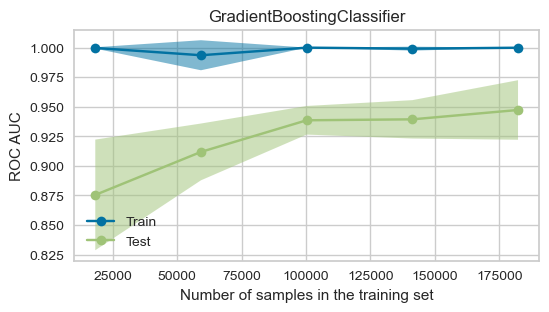

In [39]:
imba_pipeline.fit(X_train, y_train)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train, y_train, skf, title=name)

In [40]:
results = add_metrics(metrics, imba_pipeline, name, "with outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
36,GradientBoostingClassifier,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.995541,0.260736,0.867347,0.400943,0.972651,"[[56623, 241], [13, 85]]"


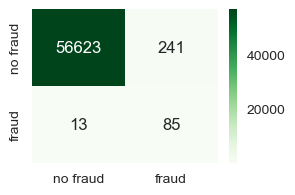

In [41]:
heatmap(metrics["conf_m"])

Без выбросов.

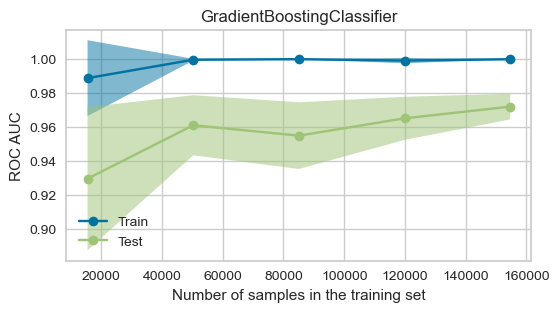

In [42]:
imba_pipeline.fit(X_train_new, y_train_new)
metrics = get_metrics(imba_pipeline, X_test, y_test)
show_learning_curve(imba_pipeline, X_train_new, y_train_new, skf, title=name)

In [43]:
results = add_metrics(metrics, imba_pipeline, name, "without outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
37,GradientBoostingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.979688,0.071255,0.897959,0.132033,0.981783,"[[55717, 1147], [10, 88]]"


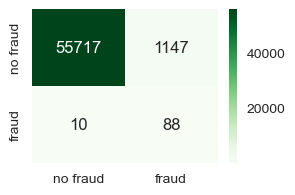

In [44]:
heatmap(metrics["conf_m"])

После обучения многих моделей и ансамблей с применением различных преобразований получилась такая картина:
- В основном результаты не сильно отличаются друг от друга
- Взвешивание классов дало мЕньший результат, по сравнению с другими вариантами (в основном)
- Модели лучше определяют целевой (1) класс на данных с очищенными выбросами, но больше ошибаются в 0 классе

Здесь образуется вопрос, который скорее относится к проблеме принятия решений. С одной стороны важно определять мошеннические транзакции, с другой же стороны - большое количество ошибок на легальных транзакциях приведет к росту недовольства со стороны пользователей. Здесь важно найти границу, баланс между слишком большим числом недовольных пользователей и слишком большим числом ошибок определения действительно мошеннических транзакций. В любом случае изменить баланс можно изменив порог принятия решения, в данном же случае все таки будем ориентироваться на показатель метрики ROC AUC, поэтому отберем 5 наиболее удачных с этой точки зрения моделей.

In [78]:
best_models = results.sort_values(by="roc_auc", ascending=False).iloc[:5]
best_models

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
37,GradientBoostingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.979688,0.071255,0.897959,0.132033,0.981783,"[[55717, 1147], [10, 88]]"
8,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.983182,0.086538,0.918367,0.158172,0.979727,"[[55914, 950], [8, 90]]"
27,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995242,0.243323,0.836735,0.377011,0.977153,"[[56609, 255], [16, 82]]"
10,SVC,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.976598,0.063604,0.918367,0.118969,0.977112,"[[55539, 1325], [8, 90]]"
1,LogisticRegression,(ColumnTransformer(transformers=[('standardsca...,witout outliers,original,0.995120,0.238372,0.836735,0.371041,0.976971,"[[56602, 262], [16, 82]]"


Для этих моделей построим кривую ROC.

In [89]:
y_preds5top = []
for estimator in best_models.model:
    y_pred = estimator.decision_function(X_test)
    y_preds5top.append(y_pred)

In [93]:
fpr, tpr, treshold = [], [], []
for y_pred in y_preds5top:
    fpr_temp, tpr_temp, treshold_temp = roc_curve(y_test, y_pred[:, 1])
    fpr.append(fpr_temp)
    tpr.append(tpr_temp)
    treshold.append(treshold_temp)

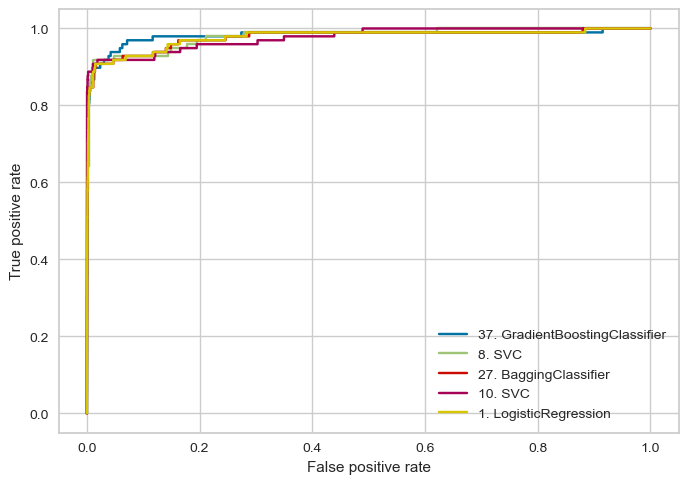

In [96]:
for fpri, tpri, name, i in zip(fpr, tpr, best_models.name, best_models.index):
    plt.plot(fpri, tpri, label=f"{i}. {name}")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

В зависимости от того, что важнее:
- выявить все мошеннические операции
- выявить как можно больше мошеннических транзакций, но минимально ошибочно определить не мошеннические как мошеннические

Можно выделить двух фаворитов:
- в первом случае это GradientBoostingClassifier 37
- во втором случае это BaggingClassifier 27 или SVC 8

Определим, что все таки большое количество ошибочных выявлений транзакций как мошеннических, больше вредит, чем помогает. Значит выберем все таки BaggingClassifier 27 как лучшую модель.

### Модели нейронных сетей

In [238]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [327]:
def myscorery(estim, X, y):
    y_pred = estim.predict_proba(X)
    return {"roc_auc": roc_auc_score(y, y_pred[:, 1])}

def lr_curve_history(hst):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    ax[0].plot(hst['loss'], label="train")
    ax[0].plot(hst['val_loss'], label='test')
    ax[0].set_title("BinaryCrossEntropyLoss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    ax[1].plot(hst['roc_auc'], label="train")
    ax[1].plot(hst['val_roc_auc'], label='test')
    ax[1].set_title("ROC AUC score")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("score")
    ax[1].legend()
    fig.show()

def get_metrics_neuron(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X, verbose=0)
    y_pred = y_pred_proba.argmax(-1)
    return {
        "accuracy":accuracy_score(y, y_pred),
        "precision":precision_score(y, y_pred),
        "recall":recall_score(y, y_pred),
        "f1":f1_score(y, y_pred),
        "roc_auc":roc_auc_score(y, y_pred_proba[:, 1]),
        "conf_m":confusion_matrix(y, y_pred),
    }
    
def test_model(estimator, X_train, y_train, X_test, y_test,
               param_grid, cv, preprocessor, n_jobs=8, smote=False):
    grid_search = GridSearchCV(
        estimator = estimator,
        param_grid = param_grid,
        scoring = myscorery,
        refit="roc_auc",
        cv = cv, n_jobs=8)
    grid_search = grid_search.fit(X_train, y_train)
    best_estim = grid_search.best_estimator_[-1]
    X_train = preprocessor.fit_transform(X_train)
    if smote:
        X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    X_test = preprocessor.transform(X_test)
    history = best_estim.fit(X_train, y_train, 
                             validation_data=(X_test, y_test))
    hst = history.history
    lr_curve_history(hst)
    metrics = get_metrics_neuron(best_estim,
                                 X_test, y_test)
    return grid_search.best_estimator_, metrics

class MulticlassAUC(tf.keras.metrics.AUC):
    """AUC for a single class in a muliticlass problem.

    Parameters
    ----------
    pos_label : int
        Label of the positive class (the one whose AUC is being computed).

    from_logits : bool, optional (default: False)
        If True, assume predictions are not standardized to be between 0 and 1.
        In this case, predictions will be squeezed into probabilities using the
        softmax function.

    sparse : bool, optional (default: True)
        If True, ground truth labels should be encoded as integer indices in the
        range [0, n_classes-1]. Otherwise, ground truth labels should be one-hot
        encoded indicator vectors (with a 1 in the true label position and 0
        elsewhere).

    **kwargs : keyword arguments
        Keyword arguments for tf.keras.metrics.AUC.__init__(). For example, the
        curve type (curve='ROC' or curve='PR').
    """

    def __init__(self, pos_label, from_logits=False, sparse=True, **kwargs):
        super().__init__(**kwargs)

        self.pos_label = pos_label
        self.from_logits = from_logits
        self.sparse = sparse

    def update_state(self, y_true, y_pred, **kwargs):
        """Accumulates confusion matrix statistics.

        Parameters
        ----------
        y_true : tf.Tensor
            The ground truth values. Either an integer tensor of shape
            (n_examples,) (if sparse=True) or a one-hot tensor of shape
            (n_examples, n_classes) (if sparse=False).

        y_pred : tf.Tensor
            The predicted values, a tensor of shape (n_examples, n_classes).

        **kwargs : keyword arguments
            Extra keyword arguments for tf.keras.metrics.AUC.update_state
            (e.g., sample_weight).
        """
        if self.sparse:
            y_true = tf.math.equal(y_true, self.pos_label)
            y_true = tf.squeeze(y_true)
        else:
            y_true = y_true[..., self.pos_label]

        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        y_pred = y_pred[..., self.pos_label]

        super().update_state(y_true, y_pred, **kwargs)

- NeuralNetwork (original data)

In [328]:
def buildModel(optimizer, units=32):
    classifier = Sequential()
    classifier.add(Dense(units = units, activation = 'relu'))
    classifier.add(Dense(units = units, activation = 'relu'))
    classifier.add(Dense(units = 2, activation = 'softmax'))
    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=[MulticlassAUC(pos_label=1, name="roc_auc")]) #, from_logits=True
    return classifier

In [329]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
#                               SMOTE(random_state=42),
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__optimizer': ['adam', "sgd"], #, 'sgd'
              'kerasclassifier__batch_size': [128, 512], #, 512
              "kerasclassifier__verbose": [0]}

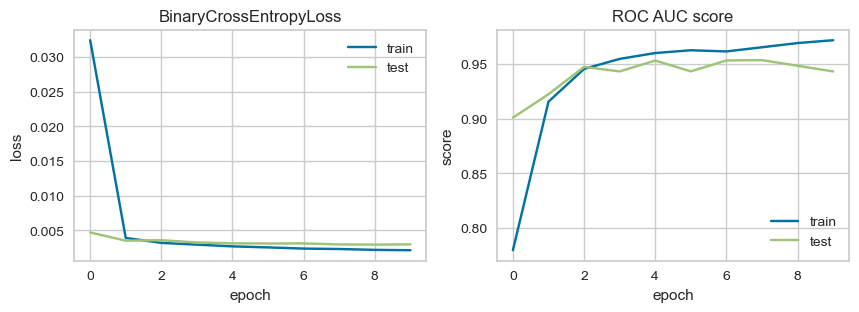

In [330]:
best_estim, metrics = test_model(imba_pipeline, X_train, y_train, X_test,
                         y_test, param_grid, skf, preprocessor, smote=False)

In [331]:
results = add_metrics(metrics, best_estim, "nn1", "with outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
38,nn1,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999421,0.835052,0.826531,0.830769,0.977698,"[[56848, 16], [17, 81]]"


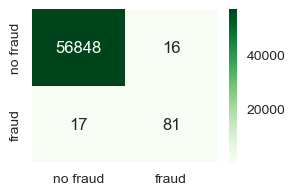

In [332]:
heatmap(metrics["conf_m"])

Без выбросов.

In [333]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
#                               SMOTE(random_state=42),
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__optimizer': ['adam', "sgd"], #, 'sgd'
              'kerasclassifier__batch_size': [128, 512], #, 512
              "kerasclassifier__verbose": [0]}

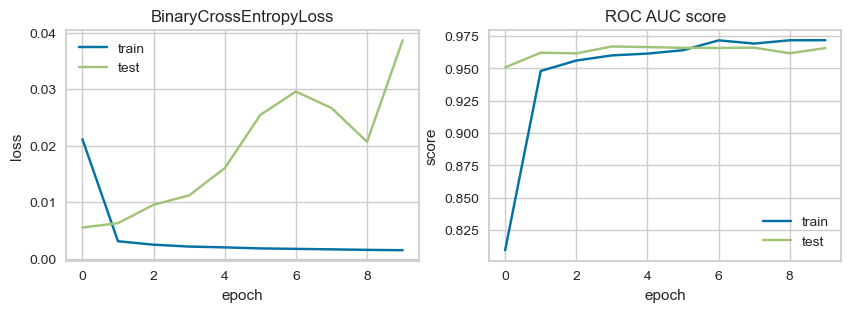

In [334]:
best_estim, metrics = test_model(imba_pipeline, X_train_new, y_train_new, X_test,
                         y_test, param_grid, skf, preprocessor, smote=False)

In [335]:
results = add_metrics(metrics, best_estim, "nn1", "without outliers", "original", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
39,nn1,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.991328,0.151408,0.877551,0.258258,0.980729,"[[56382, 482], [12, 86]]"


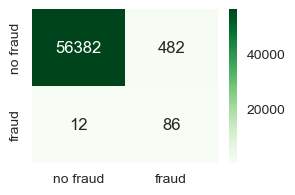

In [336]:
heatmap(metrics["conf_m"])

- NeuralNetwork (SMOTE)

In [337]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
                              SMOTE(random_state=42),
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__optimizer': ['adam', "sgd"], #, 'sgd'
              'kerasclassifier__batch_size': [128, 512], #, 512
              "kerasclassifier__verbose": [0]}

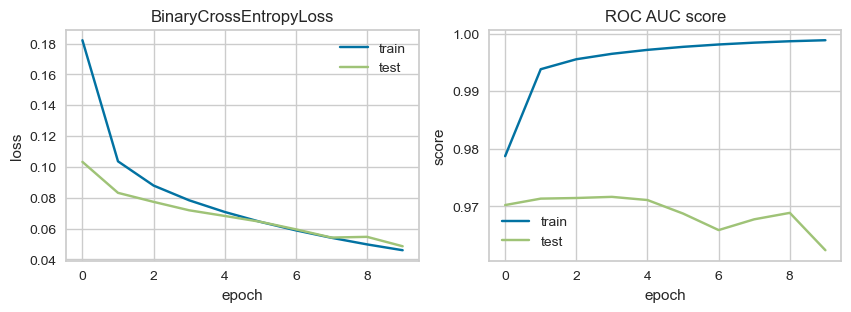

In [338]:
best_estim, metrics = test_model(imba_pipeline, X_train, y_train, X_test,
                         y_test, param_grid, skf, preprocessor, smote=True)

In [339]:
results = add_metrics(metrics, best_estim, "nn1", "with outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
40,nn1,(ColumnTransformer(transformers=[('standardsca...,with outliers,SMOTE,0.984218,0.090072,0.897959,0.163721,0.972294,"[[55975, 889], [10, 88]]"


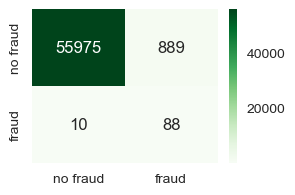

In [340]:
heatmap(metrics["conf_m"])

Без выбросов.

In [341]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
                              SMOTE(random_state=42),
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__optimizer': ['adam', "sgd"], #, 'sgd'
              'kerasclassifier__batch_size': [128, 512], #, 512
              "kerasclassifier__verbose": [0]}

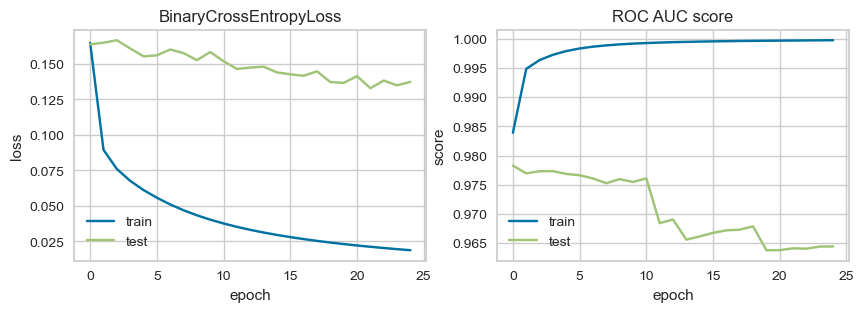

In [342]:
best_estim, metrics = test_model(imba_pipeline, X_train_new, y_train_new, X_test,
                         y_test, param_grid, skf, preprocessor, smote=True)

In [343]:
results = add_metrics(metrics, best_estim, "nn1", "without outliers", "SMOTE", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
41,nn1,(ColumnTransformer(transformers=[('standardsca...,without outliers,SMOTE,0.973509,0.057125,0.928571,0.107629,0.974456,"[[55362, 1502], [7, 91]]"


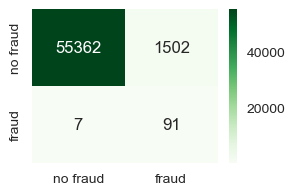

In [344]:
heatmap(metrics["conf_m"])

- NeuralNetwork (class weights)

In [345]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__optimizer': ['adam', "sgd"], #, 'sgd'
              'kerasclassifier__batch_size': [128, 512], #, 512
              "kerasclassifier__verbose": [0],
              "kerasclassifier__class_weight": [class_weights]}

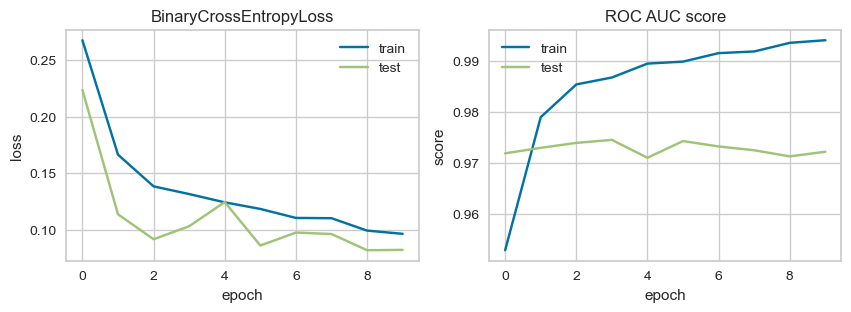

In [346]:
best_estim, metrics = test_model(imba_pipeline, X_train, y_train, X_test,
                         y_test, param_grid, skf, preprocessor, smote=False)

In [347]:
results = add_metrics(metrics, best_estim, "nn1", "with outliers", "class weights", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
42,nn1,(ColumnTransformer(transformers=[('standardsca...,with outliers,class weights,0.979162,0.070245,0.908163,0.130403,0.972206,"[[55686, 1178], [9, 89]]"


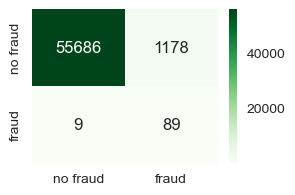

In [348]:
heatmap(metrics["conf_m"])

Без выбросов.

In [349]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__optimizer': ['adam', "sgd"], #, 'sgd'
              'kerasclassifier__batch_size': [128, 512], #, 512
              "kerasclassifier__verbose": [0],
              "kerasclassifier__class_weight": [class_weights]}

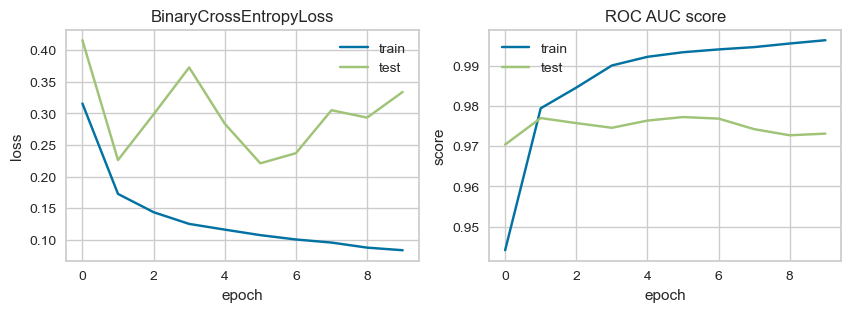

In [350]:
best_estim, metrics = test_model(imba_pipeline, X_train_new, y_train_new, X_test,
                         y_test, param_grid, skf, preprocessor, smote=False)

In [351]:
results = add_metrics(metrics, best_estim, "nn1", "without outliers", "class weights", results)
results.iloc[-1:]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
43,nn1,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.931867,0.023191,0.938776,0.045264,0.976503,"[[52989, 3875], [6, 92]]"


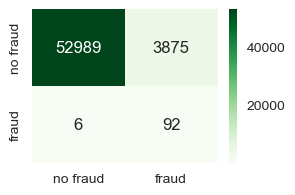

In [352]:
heatmap(metrics["conf_m"])

Результаты модели сравнимы с моделями машинного обучения. Выберем по аналогии наилучший вариант.

In [355]:
best_models = results.iloc[-6:].sort_values(by="roc_auc", ascending=False).iloc[:3]
best_models

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
39,nn1,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.991328,0.151408,0.877551,0.258258,0.980729,"[[56382, 482], [12, 86]]"
38,nn1,(ColumnTransformer(transformers=[('standardsca...,with outliers,original,0.999421,0.835052,0.826531,0.830769,0.977698,"[[56848, 16], [17, 81]]"
43,nn1,(ColumnTransformer(transformers=[('standardsca...,without outliers,class weights,0.931867,0.023191,0.938776,0.045264,0.976503,"[[52989, 3875], [6, 92]]"


In [364]:
y_preds3top = []
for estimator in best_models.model:
    y_pred = estimator.predict_proba(X_test, verbose=0)
    y_preds3top.append(y_pred)

In [365]:
fpr, tpr, treshold = [], [], []
for y_pred in y_preds3top:
    fpr_temp, tpr_temp, treshold_temp = roc_curve(y_test, y_pred[:, 1])
    fpr.append(fpr_temp)
    tpr.append(tpr_temp)
    treshold.append(treshold_temp)

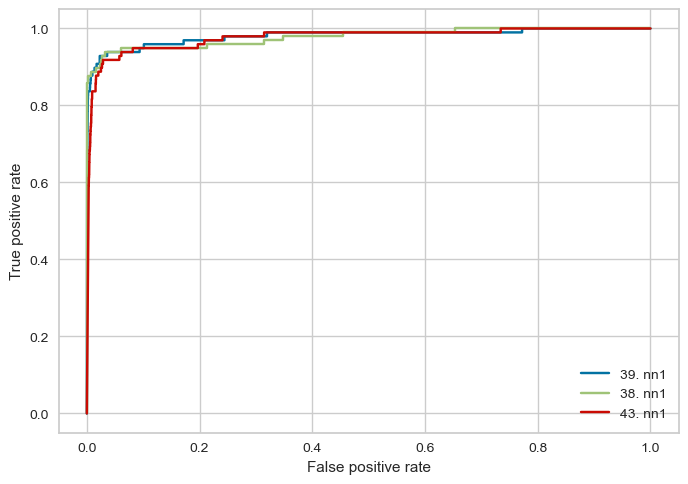

In [366]:
for fpri, tpri, name, i in zip(fpr, tpr, best_models.name, best_models.index):
    plt.plot(fpri, tpri, label=f"{i}. {name}")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

Все таки здесь однозначно модель под номером 39 показала себя лучше всего. Используя ее и лучшие настройки попробуем найти более оптимальный вариант самой модели, возможно, изменив ее структуру, сможем добиться лучшего результата.

In [370]:
best_models.loc[39].model[-1].sk_params

{'batch_size': 512, 'epochs': 10, 'optimizer': 'adam', 'verbose': 0}

In [378]:
def buildModel(lr, units=32, num_layers=2, activation="relu"):
    classifier = Sequential()
    for i in range(1, num_layers+1):
        classifier.add(Dense(units = units//i, activation = activation))
    classifier.add(Dense(units = 2, activation = 'softmax'))
    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=[MulticlassAUC(pos_label=1, name="roc_auc")]) #, from_logits=True
    return classifier

In [379]:
estimator = KerasClassifier(build_fn = buildModel)
imba_pipeline = make_pipeline(preprocessor,
                              estimator)
param_grid = {'kerasclassifier__epochs': [10, 25, 50], #10, 20, 30
              'kerasclassifier__lr': [0.01, 0.005, 0.001, 0.0005],
              'kerasclassifier__batch_size': [512],
              "kerasclassifier__verbose": [0],
              'kerasclassifier__activation': ["relu", "selu"],
              'kerasclassifier__units': [8, 32, 128],}

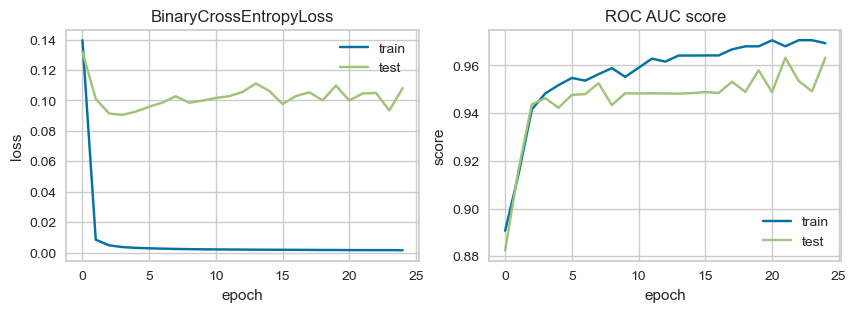

In [380]:
best_estim, metrics = test_model(imba_pipeline, X_train_new, y_train_new, X_test,
                         y_test, param_grid, skf, preprocessor, smote=False)

In [385]:
metrics

{'accuracy': 0.9846739931884414,
 'precision': 0.0916754478398314,
 'recall': 0.8877551020408163,
 'f1': 0.16618911174785103,
 'roc_auc': 0.9740007127640026,
 'conf_m': array([[56002,   862],
        [   11,    87]], dtype=int64)}

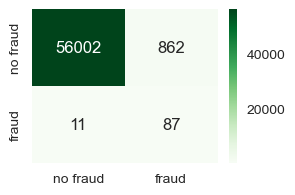

In [382]:
heatmap(metrics["conf_m"])

Положительного результата это, к сожалению, не дало, в принципе результат сравним со всеми предыдущими моделями.

Итого осталось сравнить две модели: машинного обучения и глубокого обучения (27 и 39 соответственно) и выбрать лучшую

In [387]:
results.loc[[27, 39]]

,name,model,outliers,transform,accuracy,precision,recall,f1,roc_auc,conf_m
27,BaggingClassifier,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.995242,0.243323,0.836735,0.377011,0.977153,"[[56609, 255], [16, 82]]"
39,nn1,(ColumnTransformer(transformers=[('standardsca...,without outliers,original,0.991328,0.151408,0.877551,0.258258,0.980729,"[[56382, 482], [12, 86]]"


In [389]:
fpr, tpr, treshold = [], [], []
for estimator in results.loc[[27, 39]].model:
    y_pred = estimator.predict_proba(X_test)
    fpr_temp, tpr_temp, treshold_temp = roc_curve(y_test, y_pred[:, 1])
    fpr.append(fpr_temp)
    tpr.append(tpr_temp)
    treshold.append(treshold_temp)

1781/1781 [==============================] - 1s 574us/step


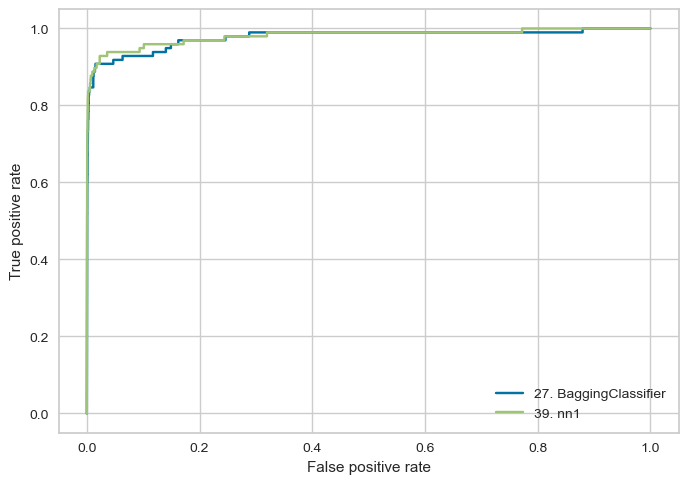

In [391]:
for fpri, tpri, name, i in zip(fpr, tpr, results.loc[[27, 39]].name, results.loc[[27, 39]].index):
    plt.plot(fpri, tpri, label=f"{i}. {name}")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

Очевидно, что модель нейронной сети показывает себя лучше. Следовательно, для работы будет выбрана модель 39.

In [394]:
#cохранить
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [2]:
#загрузить
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)